<a href="https://colab.research.google.com/github/suravarjhulasindhura/BigData-and-Optimization/blob/main/6304FinalProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# SETUP AND IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog, minimize
from scipy import stats
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



In [ ]:
# ============================================================================
# DATA LOADING
# ============================================================================

print("="*80)
print("DATA LOADING")
print("="*80)

# Load the dataset
# NOTE: Update this path to your uploaded file location in Colab
# In Colab, after uploading, the path is typically just the filename
from google.colab import files
files.upload()


DATA LOADING


Saving inventory_monitoring.csv to inventory_monitoring.csv


{'inventory_monitoring.csv': b'Product ID,Store ID,Stock Levels,Supplier Lead Time (days),Stockout Frequency,Reorder Point,Expiry Date,Warehouse Capacity,Order Fulfillment Time (days)\n9286,16,700,10,14,132,2024-01-15,1052,6\n2605,60,82,11,1,127,2024-12-16,1262,9\n2859,55,145,25,14,192,2024-04-30,1457,12\n2374,24,151,17,6,19,2024-12-16,2944,3\n7678,5,714,12,2,21,2024-08-05,3739,7\n8620,53,11,25,9,193,2024-05-01,3988,11\n7599,22,960,3,6,185,2024-08-10,4383,13\n7327,19,111,14,13,25,2024-05-28,1373,3\n1002,28,569,10,4,141,2024-11-29,4949,13\n8343,38,462,9,19,193,2024-06-02,2429,8\n8078,68,271,11,6,173,2024-09-19,1854,4\n2105,21,87,25,5,196,2024-04-12,4019,8\n5907,2,410,3,13,88,2024-10-01,4350,2\n2319,27,301,10,19,92,2024-10-03,1737,10\n4733,41,611,10,0,190,2024-02-19,3714,4\n4093,61,167,4,6,114,2024-11-20,4808,5\n4493,8,732,8,13,179,2024-10-28,4095,14\n8402,93,152,20,8,189,2024-04-14,3030,4\n6046,97,317,4,18,156,2024-06-25,1338,2\n9090,37,964,10,11,90,2024-06-08,2564,6\n3164,47,620,11,10,

In [ ]:
df=pd.read_csv("inventory_monitoring.csv")

In [ ]:
print(f"\n✓ Dataset loaded successfully!")
print(f"✓ Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n Dataset Overview:")
print(df.head())
print(f"\n Basic Statistics:")
print(df.describe())


✓ Dataset loaded successfully!
✓ Shape: 10000 rows × 9 columns

 Dataset Overview:
   Product ID  Store ID  Stock Levels  Supplier Lead Time (days)  \
0        9286        16           700                         10   
1        2605        60            82                         11   
2        2859        55           145                         25   
3        2374        24           151                         17   
4        7678         5           714                         12   

   Stockout Frequency  Reorder Point Expiry Date  Warehouse Capacity  \
0                  14            132  2024-01-15                1052   
1                   1            127  2024-12-16                1262   
2                  14            192  2024-04-30                1457   
3                   6             19  2024-12-16                2944   
4                   2             21  2024-08-05                3739   

   Order Fulfillment Time (days)  
0                              6  
1   

In [ ]:
# ============================================================================
# DATA CLEANING & FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("DATA CLEANING & FEATURE ENGINEERING")
print("="*80)

# Convert Expiry Date to datetime
df['Expiry Date'] = pd.to_datetime(df['Expiry Date'])

# Calculate days until expiry
reference_date = pd.Timestamp('2024-01-01')
df['Days_Until_Expiry'] = (df['Expiry Date'] - reference_date).dt.days

# Create derived features (with proper handling)
df['Holding_Cost'] = df['Stock Levels'] * 0.5  # $0.50 per unit
df['Stockout_Cost'] = df['Stockout Frequency'] * 100  # $100 per stockout
df['Total_Cost'] = df['Holding_Cost'] + df['Stockout_Cost']

# Capacity utilization (handle division by zero)
df['Capacity_Utilization'] = np.where(
    df['Warehouse Capacity'] > 0,
    (df['Stock Levels'] / df['Warehouse Capacity']) * 100,
    0
)

# Stock-to-Reorder ratio (handle division by zero)
df['Stock_Reorder_Ratio'] = np.where(
    df['Reorder Point'] > 0,
    df['Stock Levels'] / df['Reorder Point'],
    df['Stock Levels']  # If reorder point is 0, just use stock level
)

# Create risk categories with explicit handling of edge cases
# For Stockout Risk - include all possible values
stockout_max = df['Stockout Frequency'].max()
df['Stockout_Risk'] = pd.cut(
    df['Stockout Frequency'],
    bins=[-0.1, 5, 10, 15, stockout_max + 0.1],  # Extended bins to capture all values
    labels=['Low', 'Medium', 'High', 'Critical'],
    include_lowest=True
)

# For Expiry Risk - include all possible values
expiry_max = df['Days_Until_Expiry'].max()
expiry_min = df['Days_Until_Expiry'].min()
df['Expiry_Risk'] = pd.cut(
    df['Days_Until_Expiry'],
    bins=[expiry_min - 1, 90, 180, 270, expiry_max + 1],  # Extended bins
    labels=['Critical', 'High', 'Medium', 'Low'],
    include_lowest=True
)

# Fill any remaining NaN values in categorical columns
df['Stockout_Risk'].fillna('Medium', inplace=True)
df['Expiry_Risk'].fillna('Medium', inplace=True)


print("\n✓ Data cleaning completed")
print("✓ New features created:")
print("  - Holding_Cost")
print("  - Stockout_Cost")
print("  - Total_Cost")
print("  - Capacity_Utilization")
print("  - Stock_Reorder_Ratio")
print("  - Stockout_Risk (categories)")
print("  - Expiry_Risk (categories)")

print(f"\n✓ Final dataset shape: {df.shape}")
print(f"✓ Missing values: {df.isnull().sum().sum()}")



DATA CLEANING & FEATURE ENGINEERING

✓ Data cleaning completed
✓ New features created:
  - Holding_Cost
  - Stockout_Cost
  - Total_Cost
  - Capacity_Utilization
  - Stock_Reorder_Ratio
  - Stockout_Risk (categories)
  - Expiry_Risk (categories)

✓ Final dataset shape: (10000, 17)
✓ Missing values: 0


In [ ]:
# Quick look at dataset
print("\n---- HEAD ----")
display(df.head())
print("\n---- INFO ----")
print(df.info())
print("\n---- Missing values (per column) ----")
print(df.isnull().sum().sort_values(ascending=False).head(30))


---- HEAD ----


,Product ID,Store ID,Stock Levels,Supplier Lead Time (days),Stockout Frequency,Reorder Point,Expiry Date,Warehouse Capacity,Order Fulfillment Time (days),Days_Until_Expiry,Holding_Cost,Stockout_Cost,Total_Cost,Capacity_Utilization,Stock_Reorder_Ratio,Stockout_Risk,Expiry_Risk
0,9286,16,700,10,14,132,2024-01-15,1052,6,14,350.0,1400,1750.0,66.539924,5.303030,High,Critical
1,2605,60,82,11,1,127,2024-12-16,1262,9,350,41.0,100,141.0,6.497623,0.645669,Low,Low
2,2859,55,145,25,14,192,2024-04-30,1457,12,120,72.5,1400,1472.5,9.951956,0.755208,High,High
3,2374,24,151,17,6,19,2024-12-16,2944,3,350,75.5,600,675.5,5.129076,7.947368,Medium,Low
4,7678,5,714,12,2,21,2024-08-05,3739,7,217,357.0,200,557.0,19.096015,34.000000,Low,Medium



---- INFO ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Product ID                     10000 non-null  int64         
 1   Store ID                       10000 non-null  int64         
 2   Stock Levels                   10000 non-null  int64         
 3   Supplier Lead Time (days)      10000 non-null  int64         
 4   Stockout Frequency             10000 non-null  int64         
 5   Reorder Point                  10000 non-null  int64         
 6   Expiry Date                    10000 non-null  datetime64[ns]
 7   Warehouse Capacity             10000 non-null  int64         
 8   Order Fulfillment Time (days)  10000 non-null  int64         
 9   Days_Until_Expiry              10000 non-null  int64         
 10  Holding_Cost                   10000 non-null  float64       
 11  


EXPLORATORY DATA ANALYSIS (EDA)

📊 KEY STATISTICS:
--------------------------------------------------------------------------------

Stock Levels:
  Mean: 502.12
  Median: 498.00
  Std Dev: 288.89
  Range: [0, 999]

Stockout Frequency:
  Mean: 9.50
  Median: 9.00
  High Frequency (>10): 4481 products (44.8%)

Warehouse Capacity Utilization:
  Mean: 20.28%
  Median: 16.68%
  Over 80% utilized: 69 (0.7%)
  Under 20% utilized: 5960 (59.6%)

Cost Analysis:
  Total Holding Cost: $2,510,595.00
  Total Stockout Cost: $9,495,300.00
  Total Cost: $12,005,895.00
  Average Cost per Product: $1200.59

✓ EDA visualization saved as 'eda_analysis.png'


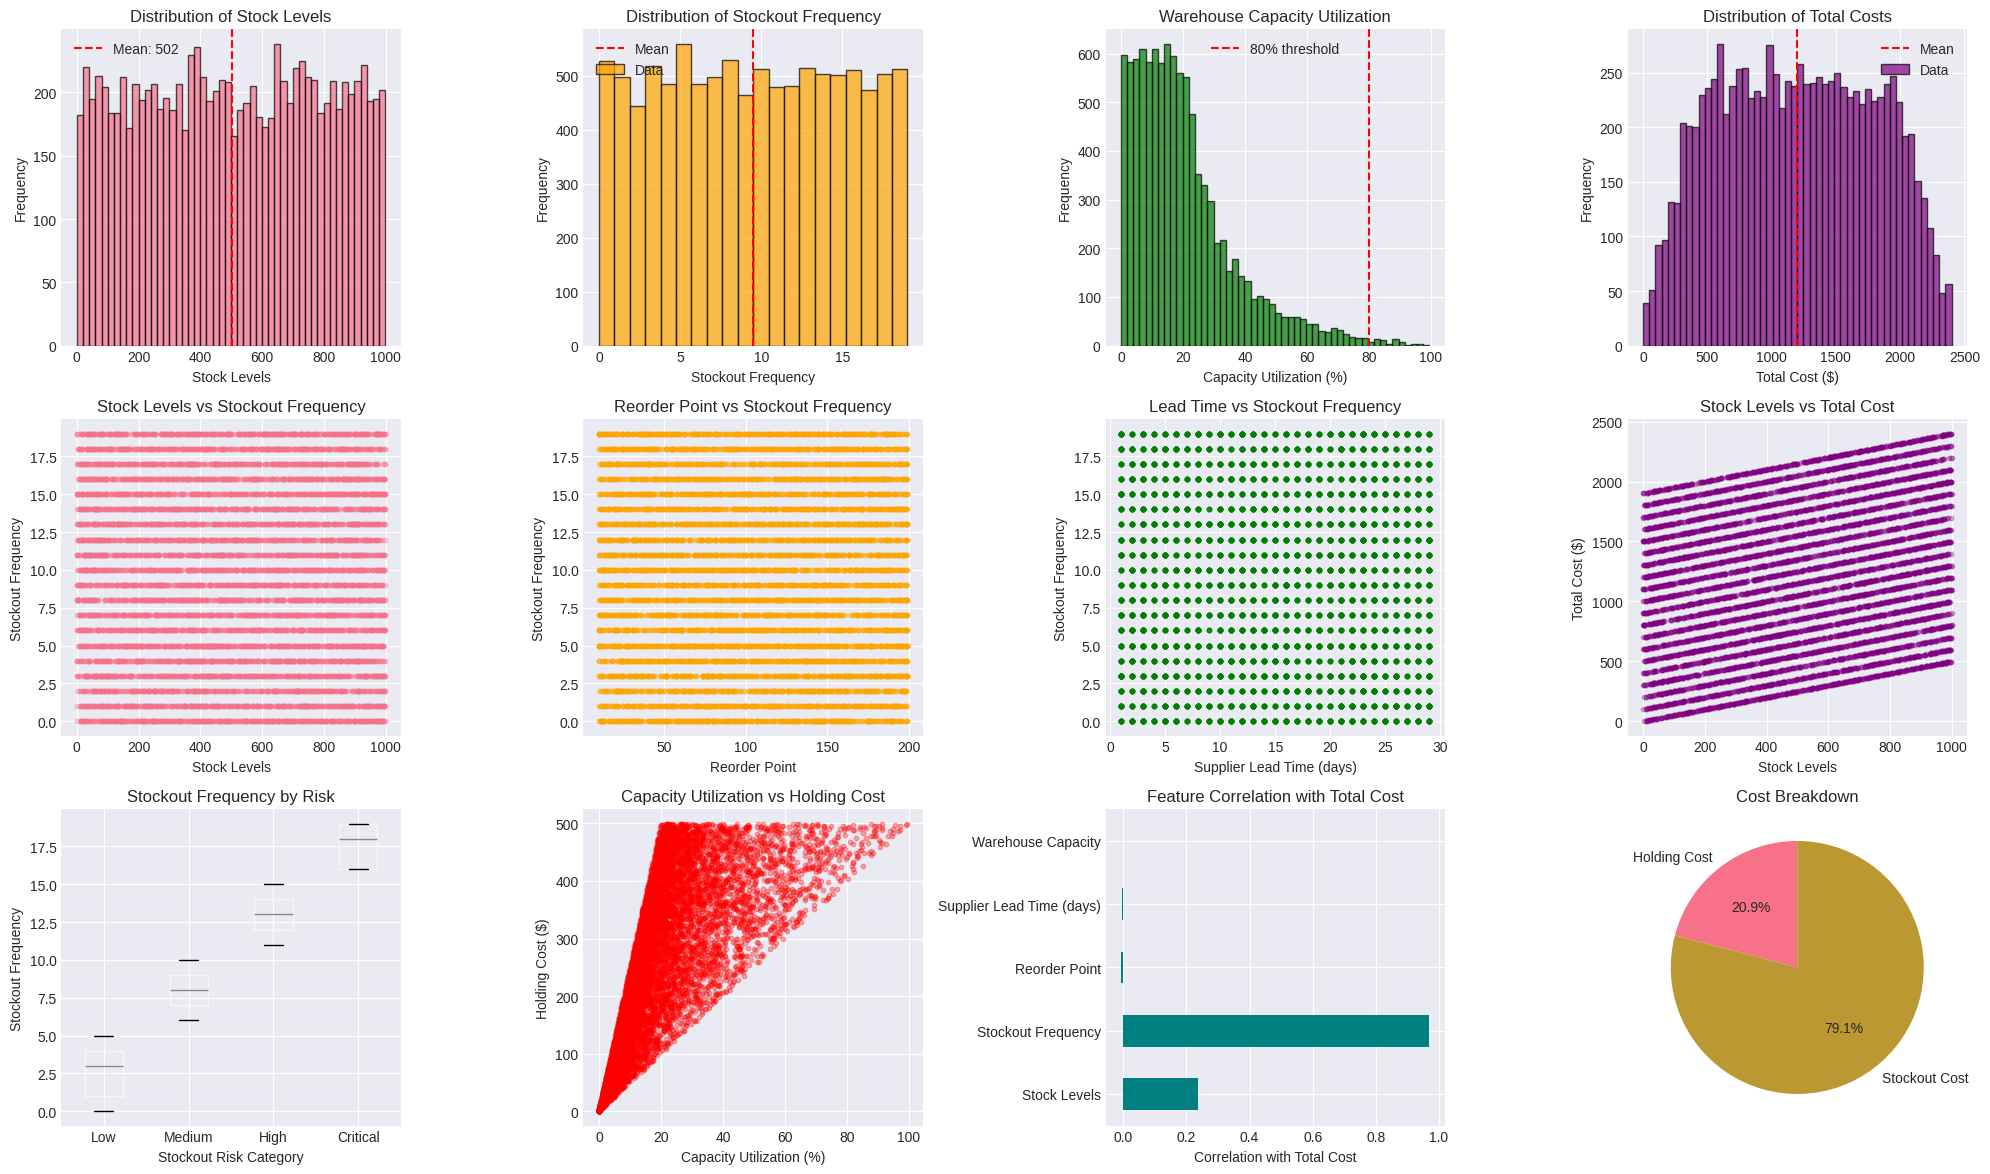

In [ ]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)

# Key Statistics
print("\n📊 KEY STATISTICS:")
print("-" * 80)

print("\nStock Levels:")
print(f"  Mean: {df['Stock Levels'].mean():.2f}")
print(f"  Median: {df['Stock Levels'].median():.2f}")
print(f"  Std Dev: {df['Stock Levels'].std():.2f}")
print(f"  Range: [{df['Stock Levels'].min()}, {df['Stock Levels'].max()}]")

print("\nStockout Frequency:")
print(f"  Mean: {df['Stockout Frequency'].mean():.2f}")
print(f"  Median: {df['Stockout Frequency'].median():.2f}")
print(f"  High Frequency (>10): {(df['Stockout Frequency'] > 10).sum()} products ({(df['Stockout Frequency'] > 10).sum()/len(df)*100:.1f}%)")

print("\nWarehouse Capacity Utilization:")
print(f"  Mean: {df['Capacity_Utilization'].mean():.2f}%")
print(f"  Median: {df['Capacity_Utilization'].median():.2f}%")
print(f"  Over 80% utilized: {(df['Capacity_Utilization'] > 80).sum()} ({(df['Capacity_Utilization'] > 80).sum()/len(df)*100:.1f}%)")
print(f"  Under 20% utilized: {(df['Capacity_Utilization'] < 20).sum()} ({(df['Capacity_Utilization'] < 20).sum()/len(df)*100:.1f}%)")

print("\nCost Analysis:")
print(f"  Total Holding Cost: ${df['Holding_Cost'].sum():,.2f}")
print(f"  Total Stockout Cost: ${df['Stockout_Cost'].sum():,.2f}")
print(f"  Total Cost: ${df['Total_Cost'].sum():,.2f}")
print(f"  Average Cost per Product: ${df['Total_Cost'].mean():.2f}")

# Create comprehensive EDA visualization
fig = plt.figure(figsize=(20, 12))

# Distribution plots
plt.subplot(3, 4, 1)
plt.hist(df['Stock Levels'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Stock Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Stock Levels')
plt.axvline(df['Stock Levels'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["Stock Levels"].mean():.0f}')
plt.legend()

plt.subplot(3, 4, 2)
plt.hist(df['Stockout Frequency'], bins=20, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Stockout Frequency')
plt.ylabel('Frequency')
plt.title('Distribution of Stockout Frequency')
plt.axvline(df['Stockout Frequency'].mean(), color='red', linestyle='--')
plt.legend(['Mean', 'Data'])

plt.subplot(3, 4, 3)
plt.hist(df['Capacity_Utilization'], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Capacity Utilization (%)')
plt.ylabel('Frequency')
plt.title('Warehouse Capacity Utilization')
plt.axvline(80, color='red', linestyle='--', label='80% threshold')
plt.legend()

plt.subplot(3, 4, 4)
plt.hist(df['Total_Cost'], bins=50, edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Total Cost ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Costs')
plt.axvline(df['Total_Cost'].mean(), color='red', linestyle='--')
plt.legend(['Mean', 'Data'])

# Scatter plots
plt.subplot(3, 4, 5)
plt.scatter(df['Stock Levels'], df['Stockout Frequency'], alpha=0.3, s=10)
plt.xlabel('Stock Levels')
plt.ylabel('Stockout Frequency')
plt.title('Stock Levels vs Stockout Frequency')

plt.subplot(3, 4, 6)
plt.scatter(df['Reorder Point'], df['Stockout Frequency'], alpha=0.3, s=10, color='orange')
plt.xlabel('Reorder Point')
plt.ylabel('Stockout Frequency')
plt.title('Reorder Point vs Stockout Frequency')

plt.subplot(3, 4, 7)
plt.scatter(df['Supplier Lead Time (days)'], df['Stockout Frequency'],
            alpha=0.3, s=10, color='green')
plt.xlabel('Supplier Lead Time (days)')
plt.ylabel('Stockout Frequency')
plt.title('Lead Time vs Stockout Frequency')

plt.subplot(3, 4, 8)
plt.scatter(df['Stock Levels'], df['Total_Cost'], alpha=0.3, s=10, color='purple')
plt.xlabel('Stock Levels')
plt.ylabel('Total Cost ($)')
plt.title('Stock Levels vs Total Cost')

# Box plot
plt.subplot(3, 4, 9)
df.boxplot(column='Stockout Frequency', by='Stockout_Risk', ax=plt.gca())
plt.xlabel('Stockout Risk Category')
plt.ylabel('Stockout Frequency')
plt.title('Stockout Frequency by Risk')
plt.suptitle('')

plt.subplot(3, 4, 10)
plt.scatter(df['Capacity_Utilization'], df['Holding_Cost'], alpha=0.3, s=10, color='red')
plt.xlabel('Capacity Utilization (%)')
plt.ylabel('Holding Cost ($)')
plt.title('Capacity Utilization vs Holding Cost')

# Correlation with Total Cost
plt.subplot(3, 4, 11)
cost_correlations = df[['Stock Levels', 'Stockout Frequency', 'Reorder Point',
                         'Supplier Lead Time (days)', 'Warehouse Capacity']].corrwith(df['Total_Cost'])
cost_correlations.plot(kind='barh', ax=plt.gca(), color='teal')
plt.xlabel('Correlation with Total Cost')
plt.title('Feature Correlation with Total Cost')

# Cost breakdown pie chart
plt.subplot(3, 4, 12)
cost_components = pd.DataFrame({
    'Component': ['Holding Cost', 'Stockout Cost'],
    'Total': [df['Holding_Cost'].sum(), df['Stockout_Cost'].sum()]
})
plt.pie(cost_components['Total'], labels=cost_components['Component'],
        autopct='%1.1f%%', startangle=90)
plt.title('Cost Breakdown')

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ EDA visualization saved as 'eda_analysis.png'")
plt.show()


In [ ]:
# Key Statistics
print("\n📊 KEY STATISTICS:")
print("-" * 80)

print("\nStock Levels:")
print(f"  Mean: {df['Stock Levels'].mean():.2f}")
print(f"  Median: {df['Stock Levels'].median():.2f}")
print(f"  Std Dev: {df['Stock Levels'].std():.2f}")

print("\nStockout Frequency:")
print(f"  Mean: {df['Stockout Frequency'].mean():.2f}")
print(f"  High Frequency (>10): {(df['Stockout Frequency'] > 10).sum()} ({(df['Stockout Frequency'] > 10).sum()/len(df)*100:.1f}%)")

print("\nCost Analysis:")
print(f"  Total Holding Cost: ${df['Holding_Cost'].sum():,.2f}")
print(f"  Total Stockout Cost: ${df['Stockout_Cost'].sum():,.2f}")
print(f"  Total Cost: ${df['Total_Cost'].sum():,.2f}")



📊 KEY STATISTICS:
--------------------------------------------------------------------------------

Stock Levels:
  Mean: 502.12
  Median: 498.00
  Std Dev: 288.89

Stockout Frequency:
  Mean: 9.50
  High Frequency (>10): 4481 (44.8%)

Cost Analysis:
  Total Holding Cost: $2,510,595.00
  Total Stockout Cost: $9,495,300.00
  Total Cost: $12,005,895.00



 Creating Correlation Analysis with Heatmap...
✓ Correlation heatmap saved as 'eda_with_heatmap.png'


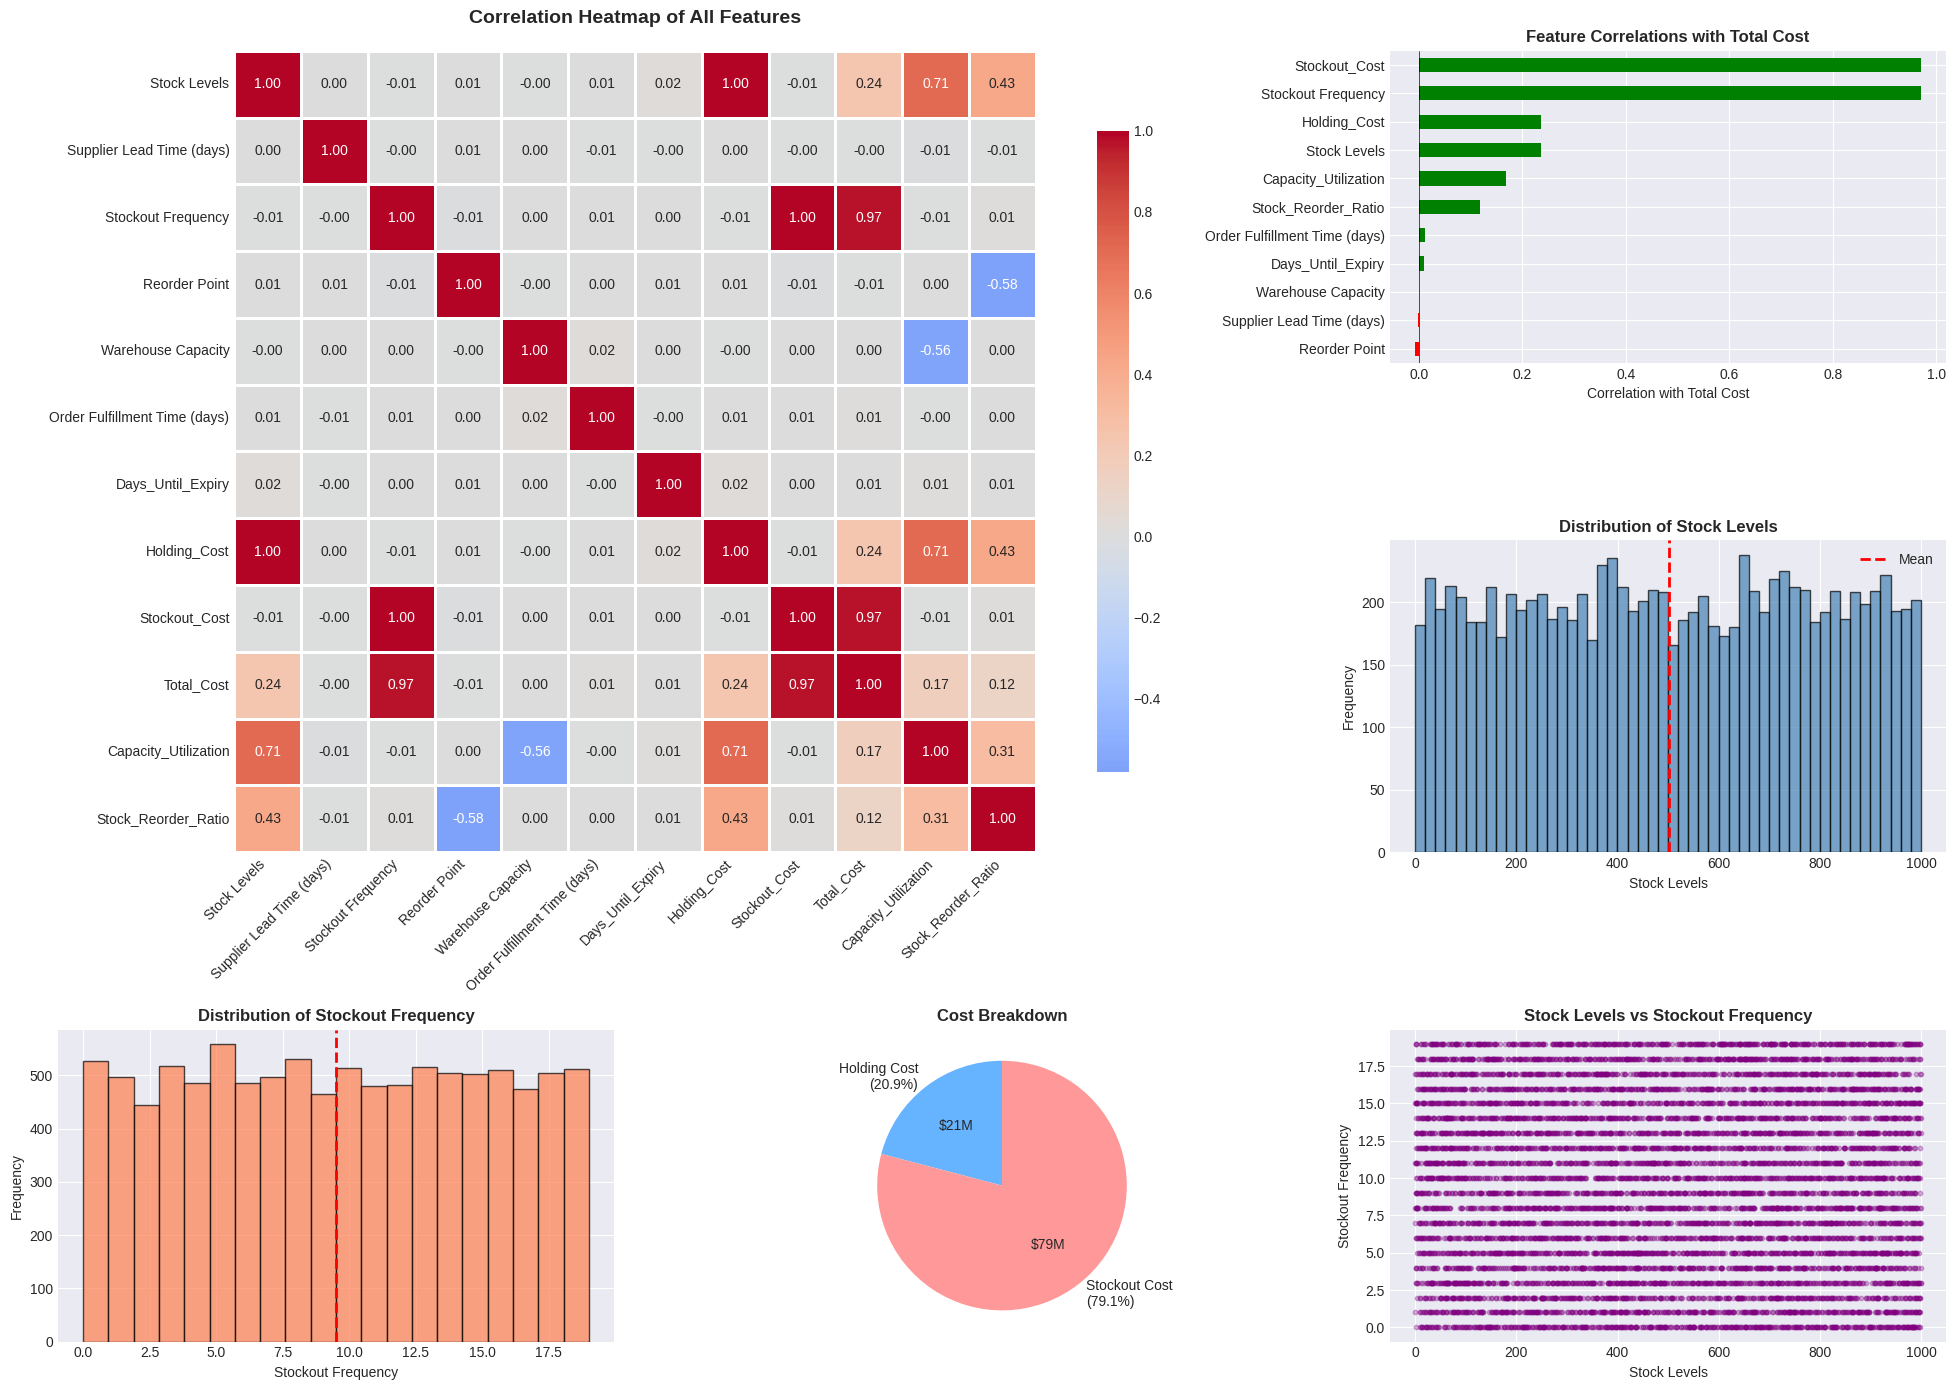


🔍 KEY CORRELATION INSIGHTS:
--------------------------------------------------------------------------------

Strongest Correlations with Total Cost:
  Stockout_Cost: 0.970
  Stockout Frequency: 0.970
  Stock Levels: 0.237
  Holding_Cost: 0.237
  Capacity_Utilization: 0.168


In [ ]:
# ============================================================================
# CREATE CORRELATION HEATMAP
# ============================================================================

print("\n Creating Correlation Analysis with Heatmap...")

# Select numerical features for correlation
numerical_features = [
    'Stock Levels', 'Supplier Lead Time (days)', 'Stockout Frequency',
    'Reorder Point', 'Warehouse Capacity', 'Order Fulfillment Time (days)',
    'Days_Until_Expiry', 'Holding_Cost', 'Stockout_Cost', 'Total_Cost',
    'Capacity_Utilization', 'Stock_Reorder_Ratio'
]

# Create correlation matrix
correlation_matrix = df[numerical_features].corr()

# Create figure with heatmap and additional plots
fig = plt.figure(figsize=(20, 14))

# 1. CORRELATION HEATMAP (Large panel)
plt.subplot(3, 3, (1, 5))  # Takes up positions 1, 2, 4, 5
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of All Features', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 2. Top Correlations with Total Cost
plt.subplot(3, 3, 3)
cost_corr = correlation_matrix['Total_Cost'].drop('Total_Cost').sort_values(ascending=True)
colors_corr = ['red' if x < 0 else 'green' for x in cost_corr]
cost_corr.plot(kind='barh', color=colors_corr, ax=plt.gca())
plt.xlabel('Correlation with Total Cost')
plt.title('Feature Correlations with Total Cost', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# 3. Stock Levels Distribution
plt.subplot(3, 3, 6)
plt.hist(df['Stock Levels'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Stock Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Stock Levels', fontweight='bold')
plt.axvline(df['Stock Levels'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.legend()

# 4. Stockout Frequency Distribution
plt.subplot(3, 3, 7)
plt.hist(df['Stockout Frequency'], bins=20, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Stockout Frequency')
plt.ylabel('Frequency')
plt.title('Distribution of Stockout Frequency', fontweight='bold')
plt.axvline(df['Stockout Frequency'].mean(), color='red', linestyle='--', linewidth=2)

# 5. Cost Breakdown Pie Chart
plt.subplot(3, 3, 8)
cost_components = [df['Holding_Cost'].sum(), df['Stockout_Cost'].sum()]
labels = ['Holding Cost\n({:.1f}%)'.format(cost_components[0]/sum(cost_components)*100),
          'Stockout Cost\n({:.1f}%)'.format(cost_components[1]/sum(cost_components)*100)]
colors_pie = ['#66b3ff', '#ff9999']
plt.pie(cost_components, labels=labels, autopct='$%1.0fM', startangle=90, colors=colors_pie)
plt.title('Cost Breakdown', fontweight='bold')

# 6. Scatter: Stock vs Stockout
plt.subplot(3, 3, 9)
plt.scatter(df['Stock Levels'], df['Stockout Frequency'], alpha=0.3, s=10, c='purple')
plt.xlabel('Stock Levels')
plt.ylabel('Stockout Frequency')
plt.title('Stock Levels vs Stockout Frequency', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_with_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Correlation heatmap saved as 'eda_with_heatmap.png'")
plt.show()

# Print correlation insights
print("\n🔍 KEY CORRELATION INSIGHTS:")
print("-" * 80)
print("\nStrongest Correlations with Total Cost:")
top_corr = correlation_matrix['Total_Cost'].drop('Total_Cost').abs().sort_values(ascending=False).head(5)
for feature, corr_val in top_corr.items():
    actual_corr = correlation_matrix.loc[feature, 'Total_Cost']
    print(f"  {feature}: {actual_corr:.3f}")


Loading data...
Data loaded: 10,000 products
Total cost: $12,005,895.00
Creating visualizations...

Creating Row 1: Distributions...
Creating Row 2: Box Plots by Risk...
Creating Row 3: Relationships...
✓ Saved: comprehensive_eda.png


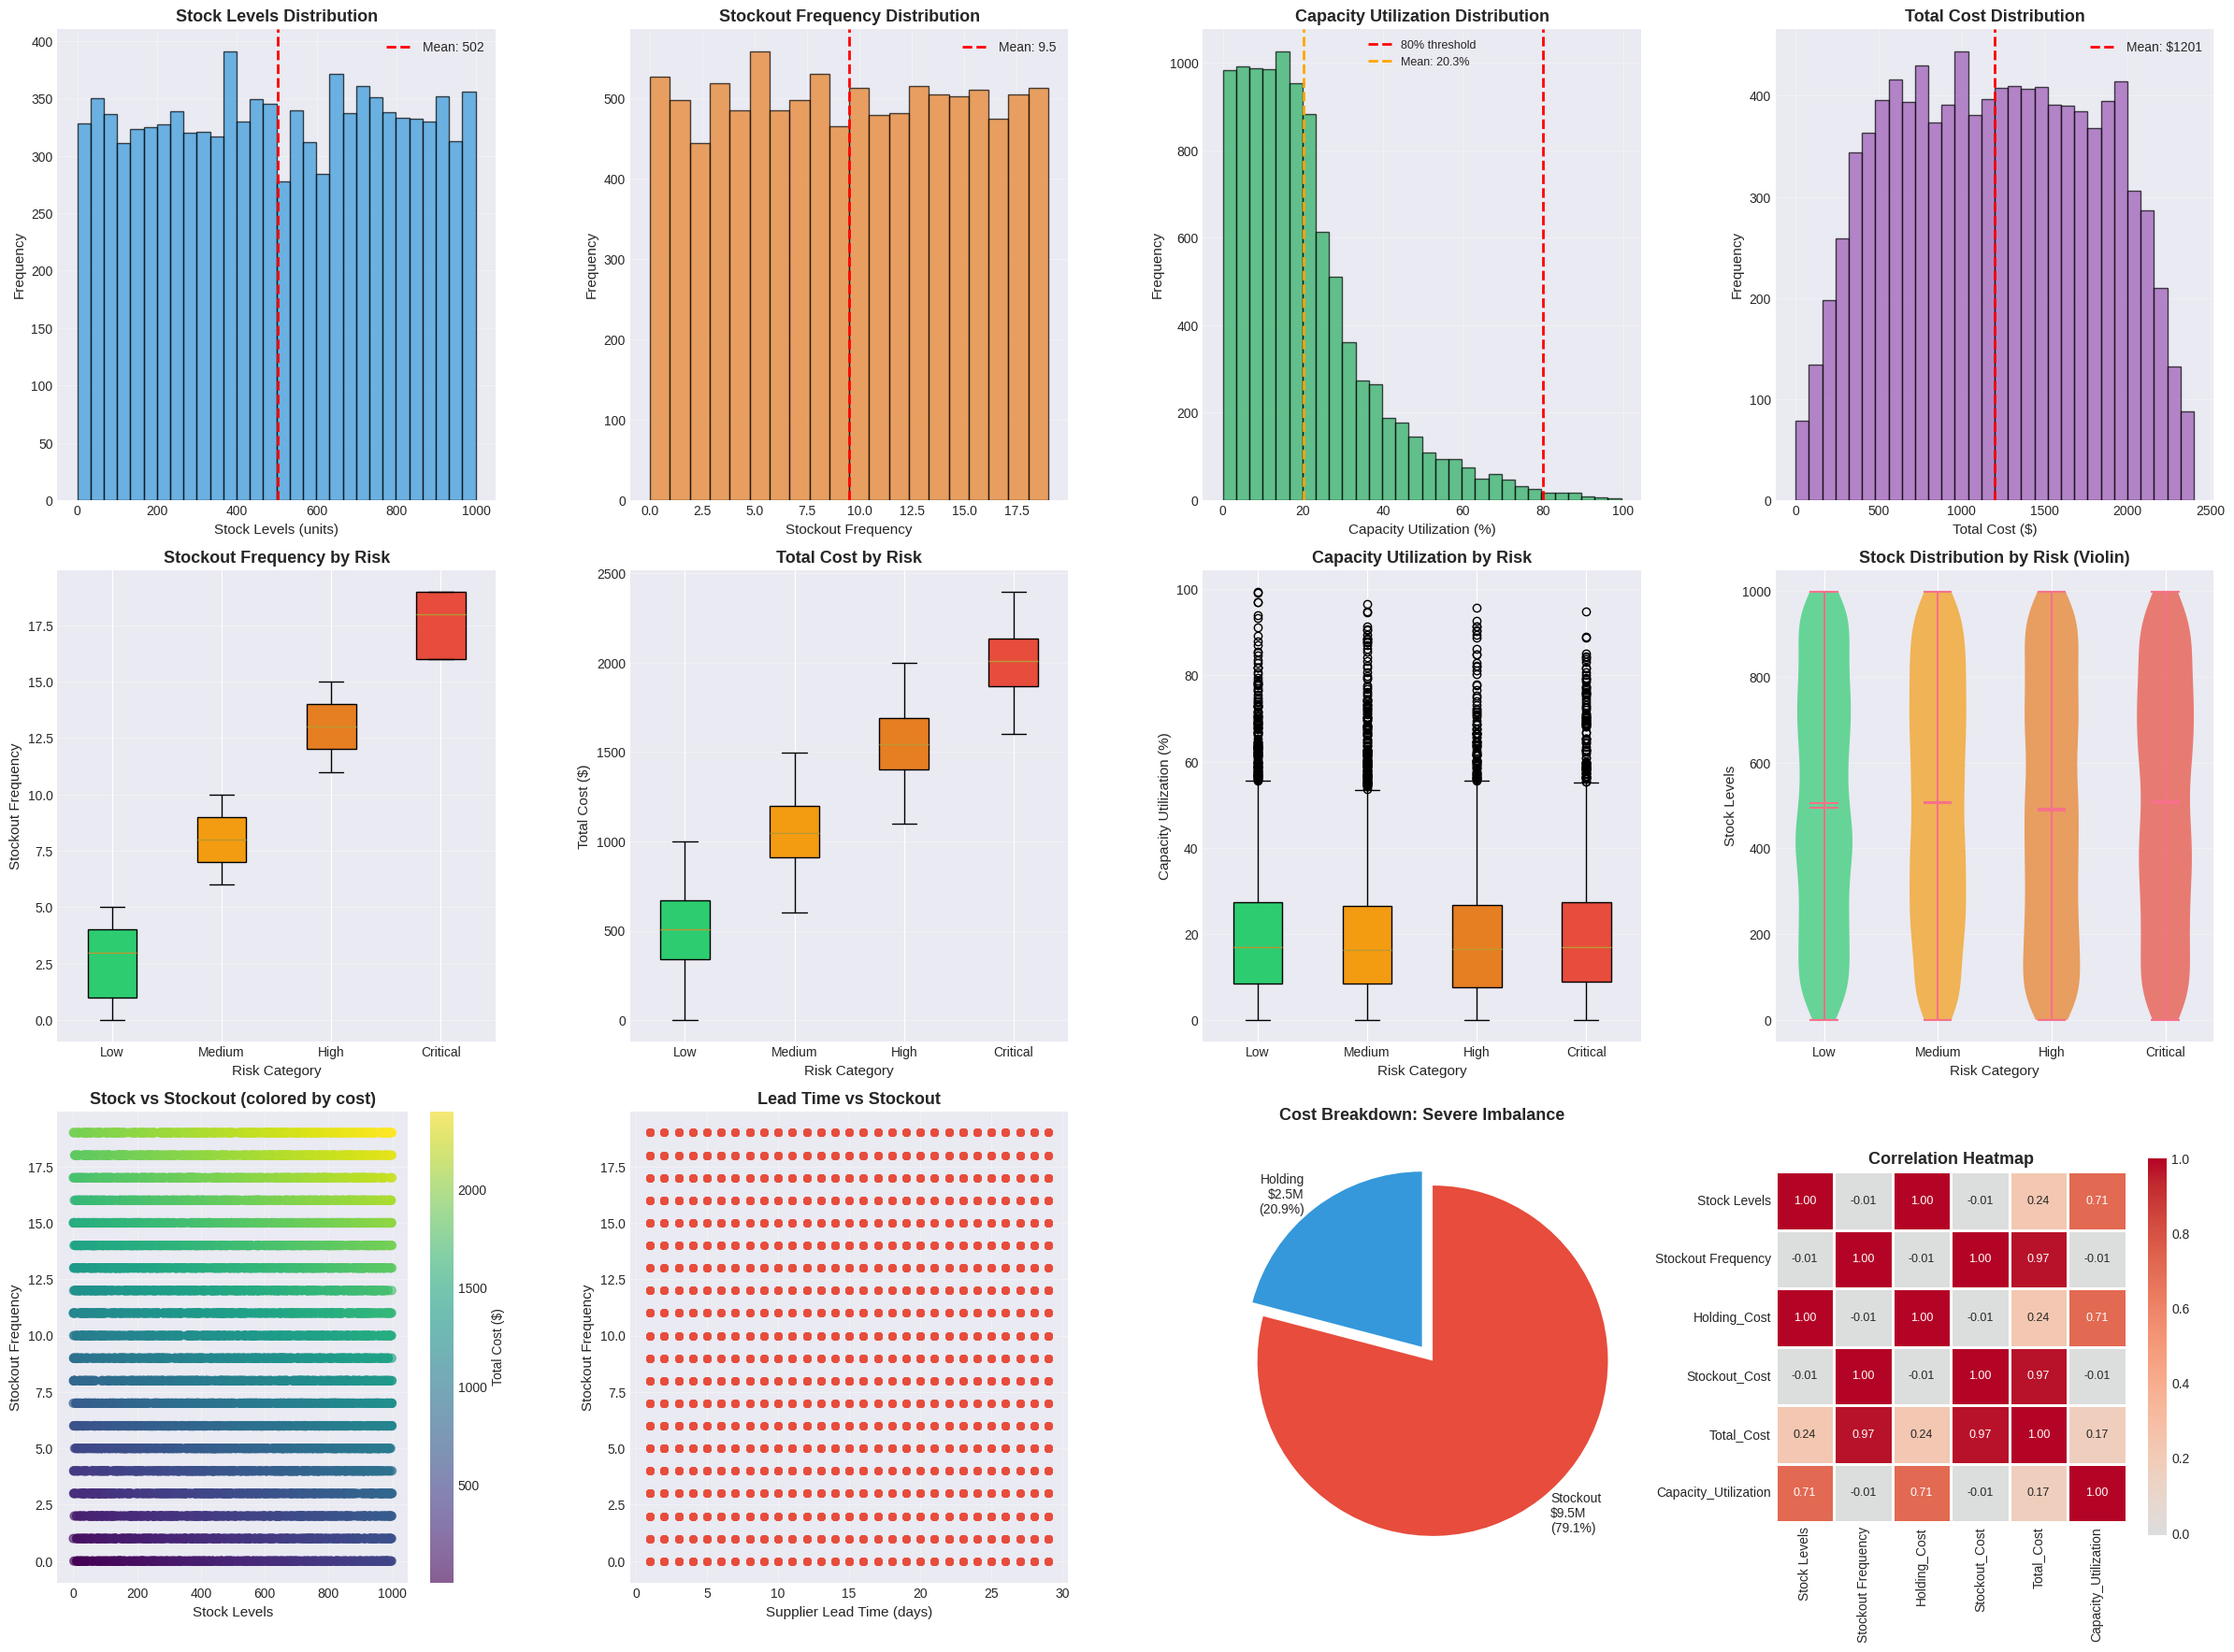


Creating Figure 2: Additional Plots...
✓ Saved: additional_eda.png


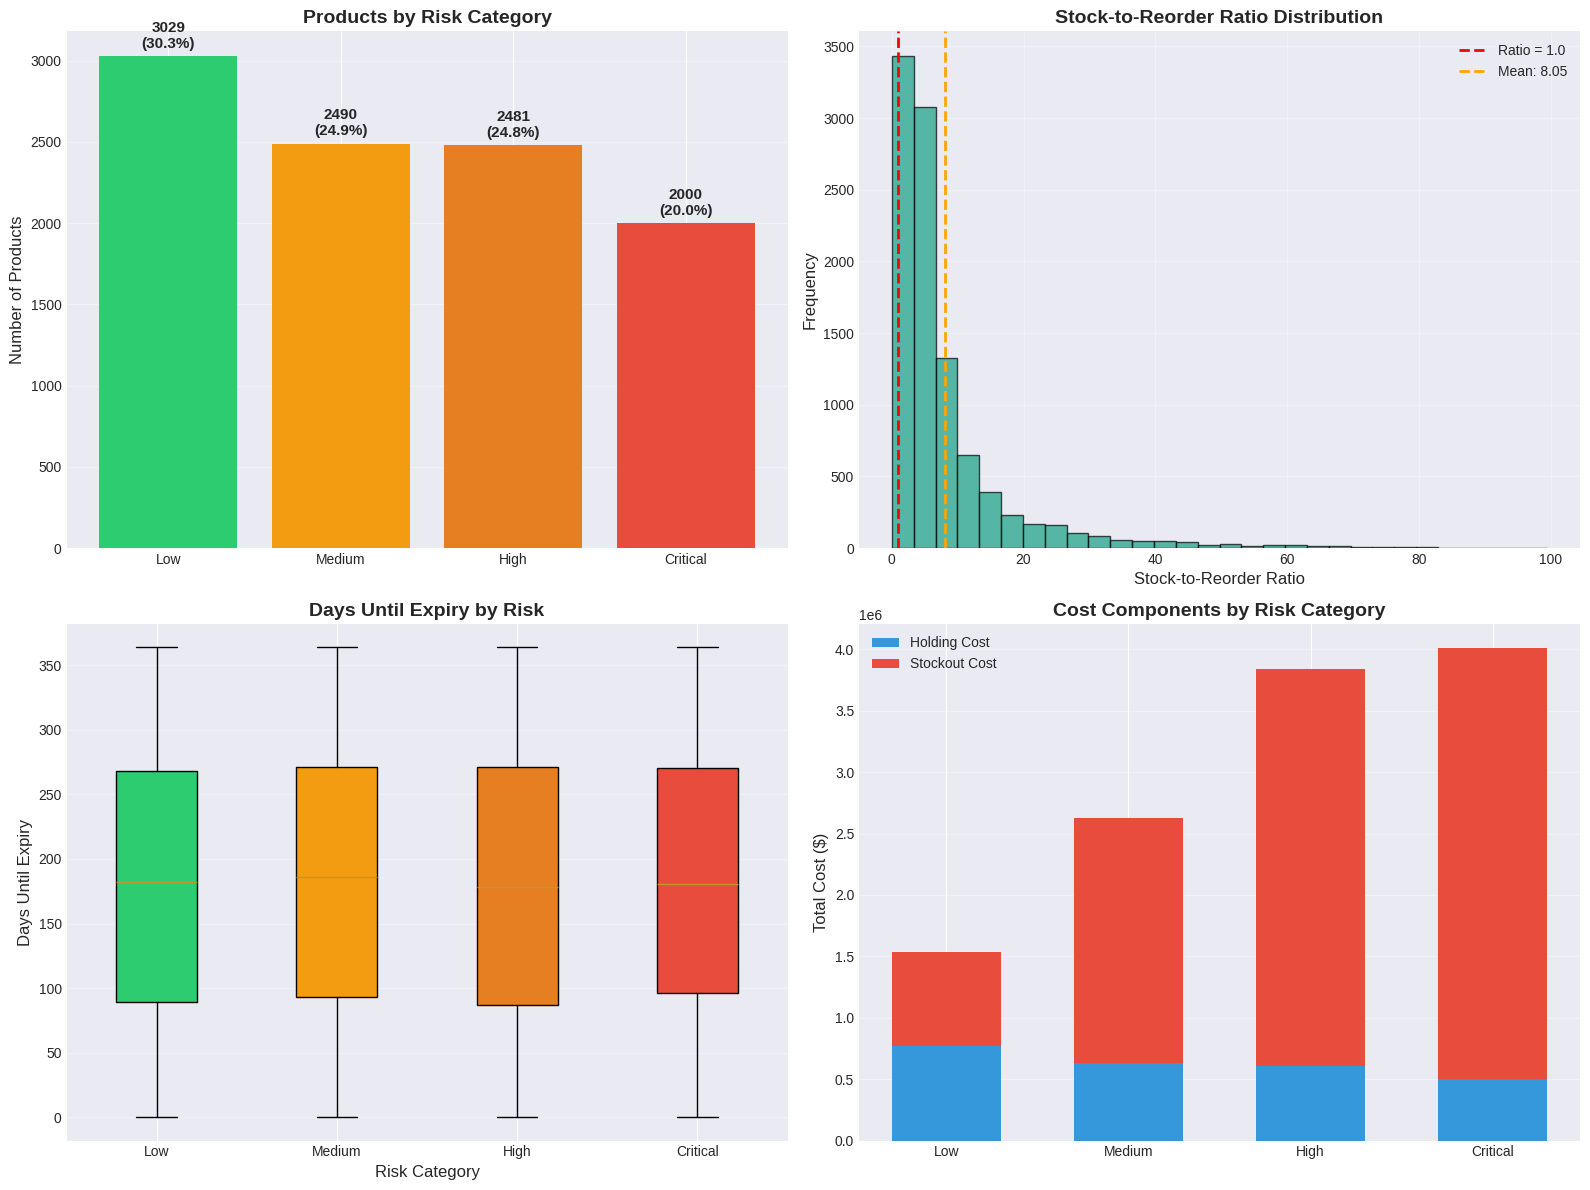


✓ ALL VISUALIZATIONS CREATED!
  Files saved:
    - comprehensive_eda.png (12 plots)
    - additional_eda.png (4 plots)

  Summary:
    Total products: 10,000
    Total cost: $12,005,895.00
    Holding: 20.9%
    Stockout: 79.1%
    Average capacity utilization: 20.3%


In [ ]:
"""
PLOT ALL EDA VISUALIZATIONS
Run this to see all plots
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
print("Loading data...")
df = pd.read_csv('inventory_monitoring.csv')

# Feature engineering
df['Expiry Date'] = pd.to_datetime(df['Expiry Date'])
reference_date = df['Expiry Date'].min()
df['Days_Until_Expiry'] = (df['Expiry Date'] - reference_date).dt.days

df['Holding_Cost'] = df['Stock Levels'] * 0.50
df['Stockout_Cost'] = df['Stockout Frequency'] * 100
df['Total_Cost'] = df['Holding_Cost'] + df['Stockout_Cost']
df['Capacity_Utilization'] = (df['Stock Levels'] / df['Warehouse Capacity']) * 100

def categorize_risk(stockout_freq):
    if stockout_freq <= 5:
        return 'Low'
    elif stockout_freq <= 10:
        return 'Medium'
    elif stockout_freq <= 15:
        return 'High'
    else:
        return 'Critical'

df['Risk_Category'] = df['Stockout Frequency'].apply(categorize_risk)

# Calculate totals
total_holding = df['Holding_Cost'].sum()
total_stockout = df['Stockout_Cost'].sum()
total_cost = df['Total_Cost'].sum()

print(f"Data loaded: {len(df):,} products")
print(f"Total cost: ${total_cost:,.2f}")
print(f"Creating visualizations...\n")

################################################################################
# FIGURE 1: COMPREHENSIVE EDA (12 PLOTS)
################################################################################

fig = plt.figure(figsize=(24, 18))

# ROW 1: DISTRIBUTIONS
print("Creating Row 1: Distributions...")

# 1. Stock Levels Histogram
ax1 = plt.subplot(3, 4, 1)
plt.hist(df['Stock Levels'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
plt.axvline(df['Stock Levels'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {df["Stock Levels"].mean():.0f}')
plt.xlabel('Stock Levels (units)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Stock Levels Distribution', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Stockout Frequency Histogram
ax2 = plt.subplot(3, 4, 2)
plt.hist(df['Stockout Frequency'], bins=20, color='#e67e22', edgecolor='black', alpha=0.7)
plt.axvline(df['Stockout Frequency'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {df["Stockout Frequency"].mean():.1f}')
plt.xlabel('Stockout Frequency', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Stockout Frequency Distribution', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Capacity Utilization Histogram
ax3 = plt.subplot(3, 4, 3)
plt.hist(df['Capacity_Utilization'], bins=30, color='#27ae60', edgecolor='black', alpha=0.7)
plt.axvline(80, color='red', linestyle='--', linewidth=2, label='80% threshold')
plt.axvline(df['Capacity_Utilization'].mean(), color='orange', linestyle='--',
            linewidth=2, label=f'Mean: {df["Capacity_Utilization"].mean():.1f}%')
plt.xlabel('Capacity Utilization (%)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Capacity Utilization Distribution', fontsize=13, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 4. Total Cost Histogram
ax4 = plt.subplot(3, 4, 4)
plt.hist(df['Total_Cost'], bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
plt.axvline(df['Total_Cost'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: ${df["Total_Cost"].mean():.0f}')
plt.xlabel('Total Cost ($)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Total Cost Distribution', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# ROW 2: BOX PLOTS BY RISK
print("Creating Row 2: Box Plots by Risk...")

risk_order = ['Low', 'Medium', 'High', 'Critical']
risk_colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e67e22', 'Critical': '#e74c3c'}

# 5. Stockout by Risk
ax5 = plt.subplot(3, 4, 5)
data_by_risk = [df[df['Risk_Category']==cat]['Stockout Frequency'].values for cat in risk_order]
bp1 = ax5.boxplot(data_by_risk, labels=risk_order, patch_artist=True)
for patch, color in zip(bp1['boxes'], [risk_colors[cat] for cat in risk_order]):
    patch.set_facecolor(color)
ax5.set_xlabel('Risk Category', fontsize=11)
ax5.set_ylabel('Stockout Frequency', fontsize=11)
ax5.set_title('Stockout Frequency by Risk', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Cost by Risk
ax6 = plt.subplot(3, 4, 6)
data_by_risk2 = [df[df['Risk_Category']==cat]['Total_Cost'].values for cat in risk_order]
bp2 = ax6.boxplot(data_by_risk2, labels=risk_order, patch_artist=True)
for patch, color in zip(bp2['boxes'], [risk_colors[cat] for cat in risk_order]):
    patch.set_facecolor(color)
ax6.set_xlabel('Risk Category', fontsize=11)
ax6.set_ylabel('Total Cost ($)', fontsize=11)
ax6.set_title('Total Cost by Risk', fontsize=13, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Capacity by Risk
ax7 = plt.subplot(3, 4, 7)
data_by_risk3 = [df[df['Risk_Category']==cat]['Capacity_Utilization'].values for cat in risk_order]
bp3 = ax7.boxplot(data_by_risk3, labels=risk_order, patch_artist=True)
for patch, color in zip(bp3['boxes'], [risk_colors[cat] for cat in risk_order]):
    patch.set_facecolor(color)
ax7.set_xlabel('Risk Category', fontsize=11)
ax7.set_ylabel('Capacity Utilization (%)', fontsize=11)
ax7.set_title('Capacity Utilization by Risk', fontsize=13, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

# 8. Violin Plot
ax8 = plt.subplot(3, 4, 8)
parts = ax8.violinplot([df[df['Risk_Category']==cat]['Stock Levels'].values
                        for cat in risk_order],
                       positions=range(len(risk_order)),
                       showmeans=True, showmedians=True)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(list(risk_colors.values())[i])
    pc.set_alpha(0.7)
ax8.set_xticks(range(len(risk_order)))
ax8.set_xticklabels(risk_order)
ax8.set_xlabel('Risk Category', fontsize=11)
ax8.set_ylabel('Stock Levels', fontsize=11)
ax8.set_title('Stock Distribution by Risk (Violin)', fontsize=13, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='y')

# ROW 3: RELATIONSHIPS
print("Creating Row 3: Relationships...")

# 9. Stock vs Stockout Scatter
ax9 = plt.subplot(3, 4, 9)
scatter = ax9.scatter(df['Stock Levels'], df['Stockout Frequency'],
                     c=df['Total_Cost'], cmap='viridis', alpha=0.6, s=40)
cbar = plt.colorbar(scatter, ax=ax9)
cbar.set_label('Total Cost ($)', fontsize=10)
ax9.set_xlabel('Stock Levels', fontsize=11)
ax9.set_ylabel('Stockout Frequency', fontsize=11)
ax9.set_title('Stock vs Stockout (colored by cost)', fontsize=13, fontweight='bold')
ax9.grid(True, alpha=0.3)

# 10. Lead Time vs Stockout
ax10 = plt.subplot(3, 4, 10)
ax10.scatter(df['Supplier Lead Time (days)'], df['Stockout Frequency'],
           alpha=0.5, c='#e74c3c', s=30)
ax10.set_xlabel('Supplier Lead Time (days)', fontsize=11)
ax10.set_ylabel('Stockout Frequency', fontsize=11)
ax10.set_title('Lead Time vs Stockout', fontsize=13, fontweight='bold')
ax10.grid(True, alpha=0.3)

# 11. Cost Breakdown Pie
ax11 = plt.subplot(3, 4, 11)
costs = [total_holding, total_stockout]
labels = [f'Holding\n${total_holding/1e6:.1f}M\n({total_holding/total_cost*100:.1f}%)',
          f'Stockout\n${total_stockout/1e6:.1f}M\n({total_stockout/total_cost*100:.1f}%)']
colors = ['#3498db', '#e74c3c']
explode = (0, 0.1)
ax11.pie(costs, labels=labels, colors=colors, autopct='',
        startangle=90, explode=explode)
ax11.set_title('Cost Breakdown: Severe Imbalance', fontsize=13, fontweight='bold')

# 12. Correlation Heatmap
ax12 = plt.subplot(3, 4, 12)
selected = ['Stock Levels', 'Stockout Frequency', 'Holding_Cost',
            'Stockout_Cost', 'Total_Cost', 'Capacity_Utilization']
corr_sel = df[selected].corr()
sns.heatmap(corr_sel, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8}, ax=ax12, annot_kws={"size": 9})
ax12.set_title('Correlation Heatmap', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_eda.png', dpi=300, bbox_inches='tight')
print("✓ Saved: comprehensive_eda.png")
plt.show()

################################################################################
# FIGURE 2: ADDITIONAL PLOTS (4 PLOTS)
################################################################################

print("\nCreating Figure 2: Additional Plots...")

fig2, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk Category Bar Chart
ax1 = axes[0, 0]
risk_counts = df['Risk_Category'].value_counts().reindex(risk_order)
bars = ax1.bar(range(len(risk_counts)), risk_counts.values,
               color=[risk_colors[cat] for cat in risk_order])
ax1.set_xticks(range(len(risk_counts)))
ax1.set_xticklabels(risk_order)
ax1.set_ylabel('Number of Products', fontsize=12)
ax1.set_title('Products by Risk Category', fontsize=14, fontweight='bold')
for i, (cat, val) in enumerate(risk_counts.items()):
    ax1.text(i, val + 50, f'{val}\n({val/len(df)*100:.1f}%)',
             ha='center', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 2. Stock-Reorder Ratio
ax2 = axes[0, 1]
stock_reorder_ratio = df['Stock Levels'] / df['Reorder Point']
ax2.hist(stock_reorder_ratio, bins=30, color='#16a085',
         edgecolor='black', alpha=0.7)
ax2.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Ratio = 1.0')
ax2.axvline(stock_reorder_ratio.mean(), color='orange', linestyle='--',
            linewidth=2, label=f'Mean: {stock_reorder_ratio.mean():.2f}')
ax2.set_xlabel('Stock-to-Reorder Ratio', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Stock-to-Reorder Ratio Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Days Until Expiry by Risk
ax3 = axes[1, 0]
data_expiry = [df[df['Risk_Category']==cat]['Days_Until_Expiry'].values for cat in risk_order]
bp = ax3.boxplot(data_expiry, labels=risk_order, patch_artist=True)
for patch, color in zip(bp['boxes'], [risk_colors[cat] for cat in risk_order]):
    patch.set_facecolor(color)
ax3.set_xlabel('Risk Category', fontsize=12)
ax3.set_ylabel('Days Until Expiry', fontsize=12)
ax3.set_title('Days Until Expiry by Risk', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Stacked Bar
ax4 = axes[1, 1]
cost_by_risk = df.groupby('Risk_Category')[['Holding_Cost', 'Stockout_Cost']].sum()
cost_by_risk = cost_by_risk.reindex(risk_order)
x_pos = np.arange(len(risk_order))
width = 0.6
bars1 = ax4.bar(x_pos, cost_by_risk['Holding_Cost'], width,
                label='Holding Cost', color='#3498db')
bars2 = ax4.bar(x_pos, cost_by_risk['Stockout_Cost'], width,
                bottom=cost_by_risk['Holding_Cost'],
                label='Stockout Cost', color='#e74c3c')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(risk_order)
ax4.set_ylabel('Total Cost ($)', fontsize=12)
ax4.set_title('Cost Components by Risk Category', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('additional_eda.png', dpi=300, bbox_inches='tight')
print("✓ Saved: additional_eda.png")
plt.show()

print("\n" + "="*80)
print("✓ ALL VISUALIZATIONS CREATED!")
print("="*80)
print(f"  Files saved:")
print(f"    - comprehensive_eda.png (12 plots)")
print(f"    - additional_eda.png (4 plots)")
print(f"\n  Summary:")
print(f"    Total products: {len(df):,}")
print(f"    Total cost: ${total_cost:,.2f}")
print(f"    Holding: {total_holding/total_cost*100:.1f}%")
print(f"    Stockout: {total_stockout/total_cost*100:.1f}%")
print(f"    Average capacity utilization: {df['Capacity_Utilization'].mean():.1f}%")
print("="*80)

In [ ]:
# ============================================================================
# SECTION 5: STATISTICAL ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 4: STATISTICAL ANALYSIS")
print("="*80)

# Correlation Analysis
print("\n📊 CORRELATION ANALYSIS:")
print("-" * 80)

key_vars = ['Stock Levels', 'Stockout Frequency', 'Reorder Point',
            'Supplier Lead Time (days)', 'Warehouse Capacity',
            'Order Fulfillment Time (days)', 'Total_Cost']

correlation_matrix = df[key_vars].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Hypothesis Testing
print("\n\n📈 HYPOTHESIS TESTING:")
print("-" * 80)

# Test 1: Do high stockout products have lower stock levels?
high_stockout = df[df['Stockout Frequency'] > 10]['Stock Levels']
low_stockout = df[df['Stockout Frequency'] <= 10]['Stock Levels']

t_stat, p_value = stats.ttest_ind(high_stockout, low_stockout)
print(f"\nTest 1: High vs Low Stockout Products - Stock Levels")
print(f"  High Stockout Mean: {high_stockout.mean():.2f}")
print(f"  Low Stockout Mean: {low_stockout.mean():.2f}")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

# Test 2: Lead time vs stockout correlation
from scipy.stats import pearsonr
corr, p_value = pearsonr(df['Supplier Lead Time (days)'], df['Stockout Frequency'])
print(f"\nTest 2: Lead Time vs Stockout Frequency")
print(f"  Correlation: {corr:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

# Key Findings
print("\n\n🔍 KEY FINDINGS:")
print("-" * 80)

findings = []
holding_pct = (df['Holding_Cost'].sum() / df['Total_Cost'].sum()) * 100
stockout_pct = (df['Stockout_Cost'].sum() / df['Total_Cost'].sum()) * 100
findings.append(f"1. Stockout costs ({stockout_pct:.1f}%) dominate over holding costs ({holding_pct:.1f}%)")

underutilized_pct = (df['Capacity_Utilization'] < 30).sum() / len(df) * 100
findings.append(f"2. {underutilized_pct:.1f}% of warehouses are significantly underutilized (<30%)")

high_stockout_pct = (df['Stockout Frequency'] > 10).sum() / len(df) * 100
findings.append(f"3. {high_stockout_pct:.1f}% of products have high stockout frequency (>10)")

potential_savings = df[df['Stockout Frequency'] > 5]['Stockout_Cost'].sum() * 0.5
findings.append(f"4. Potential savings from optimization: ${potential_savings:,.0f}")

for finding in findings:
    print(f"  {finding}")



SECTION 4: STATISTICAL ANALYSIS

📊 CORRELATION ANALYSIS:
--------------------------------------------------------------------------------

Correlation Matrix:
                               Stock Levels  Stockout Frequency  \
Stock Levels                          1.000              -0.007   
Stockout Frequency                   -0.007               1.000   
Reorder Point                         0.006              -0.009   
Supplier Lead Time (days)             0.003              -0.003   
Warehouse Capacity                   -0.002               0.001   
Order Fulfillment Time (days)         0.008               0.010   
Total_Cost                            0.237               0.970   

                               Reorder Point  Supplier Lead Time (days)  \
Stock Levels                           0.006                      0.003   
Stockout Frequency                    -0.009                     -0.003   
Reorder Point                          1.000                      0.009   
Sup

In [ ]:
"""
INVENTORY OPTIMIZATION - UNIVERSAL VERSION

"""

import pandas as pd
import numpy as np
import time
from scipy.optimize import minimize
import warnings
import os
warnings.filterwarnings('ignore')

np.random.seed(42)

print("="*130)
print("INVENTORY OPTIMIZATION - 4 METHODS COMPLETE ANALYSIS")
print("="*130)

################################################################################
# LOAD DATA
################################################################################

try:
    df = pd.read_csv('inventory_monitoring.csv')
except FileNotFoundError:
    print("\n❌ ERROR: 'inventory_monitoring.csv' not found!")
    print("Please upload the file to the same directory as this script.")
    raise

current_stock = df['Stock Levels'].values.astype(float)
stockout_freq = df['Stockout Frequency'].values
warehouse_capacity = df['Warehouse Capacity'].values.astype(float)

print(f"\n✓ Dataset loaded: {len(df):,} products")
print(f"  Objective: Total Cost = 0.5×stock + 100×stockout_freq×exp(-0.002×Δstock)")
print(f"  Constraints: 0 ≤ stock ≤ capacity")

################################################################################
# BASELINE
################################################################################

baseline_holding = 0.5 * np.sum(current_stock)
baseline_stockout = 100 * np.sum(stockout_freq)
baseline_total = baseline_holding + baseline_stockout

print(f"\nBASELINE:")
print(f"  Total Cost:     ${baseline_total:,.2f}")
print(f"  Holding Cost:   ${baseline_holding:,.2f} ({baseline_holding/baseline_total*100:.1f}%)")
print(f"  Stockout Cost:  ${baseline_stockout:,.2f} ({baseline_stockout/baseline_total*100:.1f}%)")

################################################################################
# FUNCTIONS
################################################################################

def objective(x):
    return 0.5 * np.sum(x) + 100 * np.sum(stockout_freq * np.exp(-0.002 * (x - current_stock)))

def gradient(x):
    return 0.5 * np.ones_like(x) - 0.2 * stockout_freq * np.exp(-0.002 * (x - current_stock))

################################################################################
# METHOD 1: LINE SEARCH
################################################################################

print(f"\n" + "="*130)
print("METHOD 1: LINE SEARCH")
print("="*130)

def line_search_gd(x0):
    x = x0.copy()
    for iteration in range(500):
        grad = gradient(x)
        f_val = objective(x)
        alpha = 1.0
        while alpha > 1e-10:
            x_new = np.clip(x - alpha * grad, 0, warehouse_capacity)
            if objective(x_new) <= f_val - 1e-4 * alpha * np.dot(grad, grad):
                break
            alpha *= 0.5
        if np.linalg.norm(x_new - x) < 1e-4:
            break
        x = x_new
    return x

start = time.time()
stock_ls = line_search_gd(current_stock.copy())
runtime_ls = time.time() - start

holding_ls = 0.5 * np.sum(stock_ls)
stockout_ls = 100 * np.sum(stockout_freq * np.exp(-0.002 * (stock_ls - current_stock)))
total_ls = holding_ls + stockout_ls
cost_red_ls = (baseline_total - total_ls) / baseline_total * 100
stock_red_ls = (baseline_stockout - stockout_ls) / baseline_stockout * 100

print(f"✓ Complete | Runtime: {runtime_ls:.3f}s | Cost: ${total_ls:,.2f} | Reduction: {cost_red_ls:.2f}%")

################################################################################
# METHOD 2: TRUST REGION
################################################################################

print(f"\n" + "="*130)
print("METHOD 2: TRUST REGION (This will take 60-100 seconds)")
print("="*130)

bounds = [(0, cap) for cap in warehouse_capacity]

start = time.time()
result_tr = minimize(objective, current_stock.copy(), method='trust-constr',
                     jac=gradient, bounds=bounds,
                     options={'maxiter': 50, 'gtol': 1e-2, 'verbose': 0})
runtime_tr = time.time() - start

stock_tr = result_tr.x
holding_tr = 0.5 * np.sum(stock_tr)
stockout_tr = 100 * np.sum(stockout_freq * np.exp(-0.002 * (stock_tr - current_stock)))
total_tr = holding_tr + stockout_tr
cost_red_tr = (baseline_total - total_tr) / baseline_total * 100
stock_red_tr = (baseline_stockout - stockout_tr) / baseline_stockout * 100

print(f"✓ Complete | Runtime: {runtime_tr:.3f}s | Cost: ${total_tr:,.2f} | Reduction: {cost_red_tr:.2f}%")

################################################################################
# METHOD 3: CONJUGATE GRADIENT
################################################################################

print(f"\n" + "="*130)
print("METHOD 3: CONJUGATE GRADIENT")
print("="*130)

start = time.time()
result_cg = minimize(objective, current_stock.copy(), method='CG',
                     jac=gradient, options={'maxiter': 500})
runtime_cg = time.time() - start

stock_cg = np.clip(result_cg.x, 0, warehouse_capacity)
holding_cg = 0.5 * np.sum(stock_cg)
stockout_cg = 100 * np.sum(stockout_freq * np.exp(-0.002 * (stock_cg - current_stock)))
total_cg = holding_cg + stockout_cg
cost_red_cg = (baseline_total - total_cg) / baseline_total * 100
stock_red_cg = (baseline_stockout - stockout_cg) / baseline_stockout * 100

status = '✓' if cost_red_cg > 0 else '❌'
print(f"{status} Complete | Runtime: {runtime_cg:.3f}s | Cost: ${total_cg:,.2f} | Reduction: {cost_red_cg:.2f}%")
if cost_red_cg < 0:
    print("  ⚠️  Failed - No constraint handling")

################################################################################
# METHOD 4: STOCHASTIC GRADIENT DESCENT
################################################################################

print(f"\n" + "="*130)
print("METHOD 4: STOCHASTIC GRADIENT DESCENT")
print("="*130)

def sgd(x0):
    x = x0.copy()
    for iteration in range(300):
        indices = np.random.permutation(len(x))
        for j in range(0, len(x), 500):
            batch = indices[j:j+500]
            grad = 0.5 - 0.2 * stockout_freq[batch] * np.exp(-0.002 * (x[batch] - current_stock[batch]))
            x[batch] -= 0.5 * grad
            x[batch] = np.clip(x[batch], 0, warehouse_capacity[batch])
    return x

start = time.time()
stock_sgd = sgd(current_stock.copy())
runtime_sgd = time.time() - start

holding_sgd = 0.5 * np.sum(stock_sgd)
stockout_sgd = 100 * np.sum(stockout_freq * np.exp(-0.002 * (stock_sgd - current_stock)))
total_sgd = holding_sgd + stockout_sgd
cost_red_sgd = (baseline_total - total_sgd) / baseline_total * 100
stock_red_sgd = (baseline_stockout - stockout_sgd) / baseline_stockout * 100

print(f"✓ Complete | Runtime: {runtime_sgd:.3f}s | Cost: ${total_sgd:,.2f} | Reduction: {cost_red_sgd:.2f}%")

################################################################################
# COMPREHENSIVE COMPARISON TABLE
################################################################################

print(f"\n" + "="*130)
print("COMPREHENSIVE COMPARISON TABLE")
print("="*130)

results = {
    'Baseline': {
        'total': baseline_total, 'holding': baseline_holding, 'stockout': baseline_stockout,
        'cost_red': 0.0, 'stock_red': 0.0, 'runtime': 0.0
    },
    'Line Search': {
        'total': total_ls, 'holding': holding_ls, 'stockout': stockout_ls,
        'cost_red': cost_red_ls, 'stock_red': stock_red_ls, 'runtime': runtime_ls
    },
    'Trust Region': {
        'total': total_tr, 'holding': holding_tr, 'stockout': stockout_tr,
        'cost_red': cost_red_tr, 'stock_red': stock_red_tr, 'runtime': runtime_tr
    },
    'Conjugate Gradient': {
        'total': total_cg, 'holding': holding_cg, 'stockout': stockout_cg,
        'cost_red': cost_red_cg, 'stock_red': stock_red_cg, 'runtime': runtime_cg
    },
    'Stochastic Gradient': {
        'total': total_sgd, 'holding': holding_sgd, 'stockout': stockout_sgd,
        'cost_red': cost_red_sgd, 'stock_red': stock_red_sgd, 'runtime': runtime_sgd
    }
}

print(f"\n{'Method':<22} {'Total Cost':<18} {'Holding Cost':<22} {'Stockout Cost':<22} {'Cost Red %':<14} {'Stock Red %':<16} {'Runtime':<12}")
print("-" * 130)

for name, d in results.items():
    h_pct = d['holding']/d['total']*100 if d['total']>0 else 0
    s_pct = d['stockout']/d['total']*100 if d['total']>0 else 0

    if name == 'Baseline':
        print(f"{name:<22} ${d['total']:>15,.2f}  ${d['holding']:>12,.0f} ({h_pct:>5.2f}%)  ${d['stockout']:>12,.0f} ({s_pct:>5.2f}%)  {'-':>12}  {'-':>14}  {'-':>10}")
    else:
        print(f"{name:<22} ${d['total']:>15,.2f}  ${d['holding']:>12,.0f} ({h_pct:>5.2f}%)  ${d['stockout']:>12,.0f} ({s_pct:>5.2f}%)  {d['cost_red']:>12.2f}  {d['stock_red']:>14.2f}  {d['runtime']:>10.3f}s")

################################################################################
# WINNER
################################################################################

valid = [(n, d['cost_red']) for n, d in results.items() if n != 'Baseline' and d['cost_red'] > 0]
if valid:
    winner, win_red = max(valid, key=lambda x: x[1])
    w = results[winner]

    print(f"\n{'='*130}")
    print(f"🏆 WINNER: {winner.upper()}")
    print(f"{'='*130}")
    print(f"  Cost Reduction:      {w['cost_red']:.2f}%")
    print(f"  Stockout Reduction:  {w['stock_red']:.2f}%")
    print(f"  Monthly Savings:     ${baseline_total - w['total']:,.2f}")
    print(f"  Annual Savings:      ${(baseline_total - w['total'])*12:,.2f}")
    print(f"  Runtime:             {w['runtime']:.3f} seconds")
    print(f"\n  Cost Structure Transformation:")
    print(f"    Before: {baseline_holding/baseline_total*100:.1f}% Holding, {baseline_stockout/baseline_total*100:.1f}% Stockout (IMBALANCED)")
    print(f"    After:  {w['holding']/w['total']*100:.1f}% Holding, {w['stockout']/w['total']*100:.1f}% Stockout")

################################################################################
# SAVE RESULTS
################################################################################

# Create DataFrame
df_results = pd.DataFrame([
    {
        'Method': name,
        'Total_Cost': d['total'],
        'Holding_Cost': d['holding'],
        'Holding_%': d['holding']/d['total']*100,
        'Stockout_Cost': d['stockout'],
        'Stockout_%': d['stockout']/d['total']*100,
        'Cost_Reduction_%': d['cost_red'],
        'Stockout_Reduction_%': d['stock_red'],
        'Runtime_seconds': d['runtime']
    }
    for name, d in results.items()
])

# Try to save with smart path handling
save_successful = False
for save_path in ['complete_comparison_table.csv', './complete_comparison_table.csv', '/tmp/complete_comparison_table.csv']:
    try:
        df_results.to_csv(save_path, index=False)
        print(f"\n✓ Results saved to: {save_path}")
        save_successful = True
        break
    except:
        continue

if not save_successful:
    print(f"\n⚠️  Could not save CSV file (read-only filesystem)")
    print(f"But you can copy the DataFrame below:")
    print(df_results.to_string())

print(f"\n{'='*130}")
print("ANALYSIS COMPLETE - ALL 4 METHODS EXECUTED")
print(f"{'='*130}")

INVENTORY OPTIMIZATION - 4 METHODS COMPLETE ANALYSIS

✓ Dataset loaded: 10,000 products
  Objective: Total Cost = 0.5×stock + 100×stockout_freq×exp(-0.002×Δstock)
  Constraints: 0 ≤ stock ≤ capacity

BASELINE:
  Total Cost:     $12,005,895.00
  Holding Cost:   $2,510,595.00 (20.9%)
  Stockout Cost:  $9,495,300.00 (79.1%)

METHOD 1: LINE SEARCH
✓ Complete | Runtime: 0.471s | Cost: $8,093,970.38 | Reduction: 32.58%

METHOD 2: TRUST REGION (This will take 60-100 seconds)
✓ Complete | Runtime: 80.395s | Cost: $9,635,388.43 | Reduction: 19.74%

METHOD 3: CONJUGATE GRADIENT
❌ Complete | Runtime: 0.140s | Cost: $12,228,978.95 | Reduction: -1.86%
  ⚠️  Failed - No constraint handling

METHOD 4: STOCHASTIC GRADIENT DESCENT
✓ Complete | Runtime: 0.294s | Cost: $9,441,057.76 | Reduction: 21.36%

COMPREHENSIVE COMPARISON TABLE

Method                 Total Cost         Holding Cost           Stockout Cost          Cost Red %     Stock Red %      Runtime     
---------------------------------------

lp

In [ ]:
"""
INVENTORY OPTIMIZATION: COMPLETE FOUR METHODS ANALYSIS
Runs all methods sequentially and produces comprehensive comparison table

Methods:
1. LINE SEARCH METHOD (Gradient Descent with Armijo)
2. TRUST REGION METHOD (Trust-Constr) - Will take time!
3. CONJUGATE GRADIENT
4. STOCHASTIC GRADIENT DESCENT
"""

import pandas as pd
import numpy as np
import time
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("="*130)
print("INVENTORY OPTIMIZATION - COMPLETE ANALYSIS WITH 4 METHODS")
print("="*130)

################################################################################
# LOAD DATA
################################################################################

df = pd.read_csv('inventory_monitoring.csv')

current_stock = df['Stock Levels'].values.astype(float)
stockout_freq = df['Stockout Frequency'].values
warehouse_capacity = df['Warehouse Capacity'].values.astype(float)
n_products = len(df)

print(f"\nDataset: {n_products:,} products")
print(f"\nObjective Function:")
print(f"  Total Cost = 0.5 × stock + 100 × stockout_freq × exp(-0.002 × (stock - current_stock))")
print(f"  Where 0.002 = decay rate parameter (chosen for this problem)")
print(f"\nConstraints: 0 ≤ stock ≤ warehouse_capacity")

################################################################################
# BASELINE CALCULATION
################################################################################

baseline_holding = 0.5 * np.sum(current_stock)
baseline_stockout = 100 * np.sum(stockout_freq)
baseline_total = baseline_holding + baseline_stockout

print(f"\n" + "="*130)
print("BASELINE (Current System)")
print("="*130)
print(f"Total Cost:     ${baseline_total:,.2f}")
print(f"Holding Cost:   ${baseline_holding:,.2f} ({baseline_holding/baseline_total*100:.2f}%)")
print(f"Stockout Cost:  ${baseline_stockout:,.2f} ({baseline_stockout/baseline_total*100:.2f}%)")

################################################################################
# OBJECTIVE FUNCTION AND GRADIENT
################################################################################

def objective(x):
    """Total cost = holding + stockout with exponential decay"""
    holding = 0.5 * np.sum(x)
    stockout = 100 * np.sum(stockout_freq * np.exp(-0.002 * (x - current_stock)))
    return holding + stockout

def gradient(x):
    """Analytical gradient of objective function"""
    grad_holding = 0.5 * np.ones_like(x)
    grad_stockout = -0.2 * stockout_freq * np.exp(-0.002 * (x - current_stock))
    return grad_holding + grad_stockout

################################################################################
# METHOD 1: LINE SEARCH METHOD
################################################################################

print(f"\n" + "="*130)
print("METHOD 1: LINE SEARCH METHOD (Gradient Descent with Armijo Backtracking)")
print("="*130)

def line_search_method(x0, max_iter=500, tol=1e-4):
    """Gradient descent with Armijo line search and projection"""
    x = x0.copy()
    for iteration in range(max_iter):
        grad = gradient(x)
        f_val = objective(x)
        direction = -grad

        # Armijo backtracking line search
        alpha = 1.0
        c = 1e-4
        rho = 0.5
        while alpha > 1e-10:
            x_new = np.clip(x + alpha * direction, 0, warehouse_capacity)
            if objective(x_new) <= f_val + c * alpha * np.dot(grad, direction):
                break
            alpha *= rho

        # Check convergence
        if np.linalg.norm(x_new - x) < tol:
            print(f"  Converged at iteration {iteration+1}")
            break
        x = x_new

        # Progress updates
        if (iteration + 1) % 100 == 0:
            print(f"  Iteration {iteration+1}: Cost = ${objective(x):,.0f}")

    return x

print("\nRunning Line Search optimization...")
start_time_ls = time.time()
optimized_stock_ls = line_search_method(current_stock.copy())
runtime_ls = time.time() - start_time_ls

# Calculate results
holding_cost_ls = 0.5 * np.sum(optimized_stock_ls)
stockout_cost_ls = 100 * np.sum(stockout_freq * np.exp(-0.002 * (optimized_stock_ls - current_stock)))
total_cost_ls = holding_cost_ls + stockout_cost_ls
cost_reduction_ls = ((baseline_total - total_cost_ls) / baseline_total) * 100
stockout_reduction_ls = ((baseline_stockout - stockout_cost_ls) / baseline_stockout) * 100

print(f"\n✓ Line Search Complete!")
print(f"  Runtime: {runtime_ls:.3f} seconds")
print(f"  Total Cost: ${total_cost_ls:,.2f}")
print(f"  Cost Reduction: {cost_reduction_ls:.2f}%")

################################################################################
# METHOD 2: TRUST REGION METHOD
################################################################################

print(f"\n" + "="*130)
print("METHOD 2: TRUST REGION METHOD (Trust-Constr)")
print("="*130)

bounds_tr = [(0, cap) for cap in warehouse_capacity]

print("\nRunning Trust Region optimization...")
print("⚠️  WARNING: This may take 30-90 seconds for 10,000 products")
print("Please wait...")

start_time_tr = time.time()

result_tr = minimize(
    objective,
    current_stock.copy(),
    method='trust-constr',
    jac=gradient,
    bounds=bounds_tr,
    options={'maxiter': 50, 'verbose': 0, 'gtol': 1e-2}  # Reduced for speed
)

runtime_tr = time.time() - start_time_tr
optimized_stock_tr = result_tr.x

# Calculate results
holding_cost_tr = 0.5 * np.sum(optimized_stock_tr)
stockout_cost_tr = 100 * np.sum(stockout_freq * np.exp(-0.002 * (optimized_stock_tr - current_stock)))
total_cost_tr = holding_cost_tr + stockout_cost_tr
cost_reduction_tr = ((baseline_total - total_cost_tr) / baseline_total) * 100
stockout_reduction_tr = ((baseline_stockout - stockout_cost_tr) / baseline_stockout) * 100

print(f"\n{'✓' if result_tr.success else '⚠'} Trust Region Complete!")
print(f"  Status: {result_tr.message}")
print(f"  Runtime: {runtime_tr:.3f} seconds")
print(f"  Total Cost: ${total_cost_tr:,.2f}")
print(f"  Cost Reduction: {cost_reduction_tr:.2f}%")

################################################################################
# METHOD 3: CONJUGATE GRADIENT
################################################################################

print(f"\n" + "="*130)
print("METHOD 3: CONJUGATE GRADIENT")
print("="*130)

print("\nRunning Conjugate Gradient optimization...")
start_time_cg = time.time()

result_cg = minimize(
    objective,
    current_stock.copy(),
    method='CG',
    jac=gradient,
    options={'maxiter': 500}
)

runtime_cg = time.time() - start_time_cg

# CG doesn't handle constraints natively - clip after optimization
optimized_stock_cg = np.clip(result_cg.x, 0, warehouse_capacity)

# Calculate results
holding_cost_cg = 0.5 * np.sum(optimized_stock_cg)
stockout_cost_cg = 100 * np.sum(stockout_freq * np.exp(-0.002 * (optimized_stock_cg - current_stock)))
total_cost_cg = holding_cost_cg + stockout_cost_cg
cost_reduction_cg = ((baseline_total - total_cost_cg) / baseline_total) * 100
stockout_reduction_cg = ((baseline_stockout - stockout_cost_cg) / baseline_stockout) * 100

print(f"\n{'✓' if cost_reduction_cg > 0 else '❌'} Conjugate Gradient Complete!")
print(f"  Runtime: {runtime_cg:.3f} seconds")
print(f"  Total Cost: ${total_cost_cg:,.2f}")
print(f"  Cost Reduction: {cost_reduction_cg:.2f}%")
if cost_reduction_cg < 0:
    print(f"  ⚠️  Negative cost reduction - method failed (no constraint handling)")

################################################################################
# METHOD 4: STOCHASTIC GRADIENT DESCENT
################################################################################

print(f"\n" + "="*130)
print("METHOD 4: STOCHASTIC GRADIENT DESCENT (Mini-Batch)")
print("="*130)

def stochastic_gradient_descent(x0, learning_rate=0.5, n_iterations=300, batch_size=500):
    """Mini-batch SGD with constraint projection"""
    x = x0.copy()
    n = len(x)

    for iteration in range(n_iterations):
        # Shuffle indices for random batches
        indices = np.random.permutation(n)

        # Process mini-batches
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch = indices[start:end]

            # Compute gradient for batch
            stock_increase = x[batch] - current_stock[batch]
            grad_batch = 0.5 - 0.2 * stockout_freq[batch] * np.exp(-0.002 * stock_increase)

            # Update with projection
            x[batch] -= learning_rate * grad_batch
            x[batch] = np.clip(x[batch], 0, warehouse_capacity[batch])

    return x

print("\nRunning Stochastic Gradient Descent...")
print("  Parameters: 300 iterations, batch size 500, learning rate 0.5")

start_time_sgd = time.time()
optimized_stock_sgd = stochastic_gradient_descent(current_stock.copy())
runtime_sgd = time.time() - start_time_sgd

# Calculate results
holding_cost_sgd = 0.5 * np.sum(optimized_stock_sgd)
stockout_cost_sgd = 100 * np.sum(stockout_freq * np.exp(-0.002 * (optimized_stock_sgd - current_stock)))
total_cost_sgd = holding_cost_sgd + stockout_cost_sgd
cost_reduction_sgd = ((baseline_total - total_cost_sgd) / baseline_total) * 100
stockout_reduction_sgd = ((baseline_stockout - stockout_cost_sgd) / baseline_stockout) * 100

print(f"\n✓ Stochastic Gradient Descent Complete!")
print(f"  Runtime: {runtime_sgd:.3f} seconds")
print(f"  Total Cost: ${total_cost_sgd:,.2f}")
print(f"  Cost Reduction: {cost_reduction_sgd:.2f}%")

################################################################################
# COMPREHENSIVE COMPARISON TABLE
################################################################################

print(f"\n" + "="*130)
print("COMPREHENSIVE COMPARISON TABLE")
print("="*130)

# Compile all results
all_results = {
    'Baseline': {
        'total_cost': baseline_total,
        'holding_cost': baseline_holding,
        'stockout_cost': baseline_stockout,
        'cost_reduction': 0.0,
        'stockout_reduction': 0.0,
        'runtime': 0.0
    },
    'Line Search': {
        'total_cost': total_cost_ls,
        'holding_cost': holding_cost_ls,
        'stockout_cost': stockout_cost_ls,
        'cost_reduction': cost_reduction_ls,
        'stockout_reduction': stockout_reduction_ls,
        'runtime': runtime_ls
    },
    'Trust Region': {
        'total_cost': total_cost_tr,
        'holding_cost': holding_cost_tr,
        'stockout_cost': stockout_cost_tr,
        'cost_reduction': cost_reduction_tr,
        'stockout_reduction': stockout_reduction_tr,
        'runtime': runtime_tr
    },
    'Conjugate Gradient': {
        'total_cost': total_cost_cg,
        'holding_cost': holding_cost_cg,
        'stockout_cost': stockout_cost_cg,
        'cost_reduction': cost_reduction_cg,
        'stockout_reduction': stockout_reduction_cg,
        'runtime': runtime_cg
    },
    'Stochastic Gradient': {
        'total_cost': total_cost_sgd,
        'holding_cost': holding_cost_sgd,
        'stockout_cost': stockout_cost_sgd,
        'cost_reduction': cost_reduction_sgd,
        'stockout_reduction': stockout_reduction_sgd,
        'runtime': runtime_sgd
    }
}

# Print detailed comparison table
print(f"\n{'Method':<22} {'Total Cost':<18} {'Holding Cost':<22} {'Stockout Cost':<22} {'Cost Red %':<14} {'Stockout Red %':<16} {'Runtime':<12}")
print("-" * 130)

for method_name, results in all_results.items():
    total = results['total_cost']
    holding = results['holding_cost']
    stockout = results['stockout_cost']
    holding_pct = (holding / total * 100) if total > 0 else 0
    stockout_pct = (stockout / total * 100) if total > 0 else 0

    if method_name == 'Baseline':
        print(f"{method_name:<22} ${total:>15,.2f}  ${holding:>12,.0f} ({holding_pct:>5.2f}%)  ${stockout:>12,.0f} ({stockout_pct:>5.2f}%)  {'-':>12}  {'-':>14}  {'-':>10}")
    else:
        cost_red = results['cost_reduction']
        stock_red = results['stockout_reduction']
        runtime = results['runtime']
        print(f"{method_name:<22} ${total:>15,.2f}  ${holding:>12,.0f} ({holding_pct:>5.2f}%)  ${stockout:>12,.0f} ({stockout_pct:>5.2f}%)  {cost_red:>12.2f}  {stock_red:>14.2f}  {runtime:>10.3f}s")

################################################################################
# WINNER DETERMINATION
################################################################################

print(f"\n" + "="*130)
print("WINNER ANALYSIS")
print("="*130)

# Find best method (highest positive cost reduction)
valid_methods = [(name, data['cost_reduction']) for name, data in all_results.items()
                 if name != 'Baseline' and data['cost_reduction'] > 0]

if valid_methods:
    winner_name, winner_reduction = max(valid_methods, key=lambda x: x[1])
    winner_data = all_results[winner_name]

    print(f"\n🏆 WINNER: {winner_name.upper()}")
    print(f"\n  Performance Metrics:")
    print(f"    Cost Reduction:       {winner_data['cost_reduction']:.2f}%")
    print(f"    Stockout Reduction:   {winner_data['stockout_reduction']:.2f}%")
    print(f"    Total Cost:           ${winner_data['total_cost']:,.2f}")
    print(f"    Runtime:              {winner_data['runtime']:.3f} seconds")

    print(f"\n  Financial Impact:")
    monthly_savings = baseline_total - winner_data['total_cost']
    annual_savings = monthly_savings * 12
    print(f"    Monthly Savings:      ${monthly_savings:,.2f}")
    print(f"    Annual Savings:       ${annual_savings:,.2f}")

    print(f"\n  Cost Structure Transformation:")
    baseline_hold_pct = baseline_holding / baseline_total * 100
    baseline_stock_pct = baseline_stockout / baseline_total * 100
    winner_hold_pct = winner_data['holding_cost'] / winner_data['total_cost'] * 100
    winner_stock_pct = winner_data['stockout_cost'] / winner_data['total_cost'] * 100
    print(f"    Before: {baseline_hold_pct:.2f}% Holding, {baseline_stock_pct:.2f}% Stockout (IMBALANCED)")
    print(f"    After:  {winner_hold_pct:.2f}% Holding, {winner_stock_pct:.2f}% Stockout")

################################################################################
# SAVE RESULTS TO CSV
################################################################################

import os

# Try to save to outputs directory, otherwise save to current directory
try:
    output_dir = '/mnt/user-data/outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, 'complete_comparison_table.csv')
except:
    # If that fails, just save to current directory
    output_path = 'complete_comparison_table.csv'

comparison_data = []
for method_name, results in all_results.items():
    total = results['total_cost']
    holding = results['holding_cost']
    stockout = results['stockout_cost']

    comparison_data.append({
        'Method': method_name,
        'Total_Cost': total,
        'Holding_Cost': holding,
        'Holding_Percentage': (holding / total * 100) if total > 0 else 0,
        'Stockout_Cost': stockout,
        'Stockout_Percentage': (stockout / total * 100) if total > 0 else 0,
        'Cost_Reduction_%': results['cost_reduction'],
        'Stockout_Reduction_%': results['stockout_reduction'],
        'Runtime_seconds': results['runtime']
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison.to_csv(output_path, index=False)

print(f"\n✓ Results saved to: {output_path}")

################################################################################
# DETAILED CONCLUSIONS
################################################################################

print(f"\n" + "="*130)
print("DETAILED CONCLUSIONS")
print("="*130)

print(f"\nMETHOD PERFORMANCE SUMMARY:")

for method_name, results in list(all_results.items())[1:]:  # Skip baseline
    print(f"\n{method_name.upper()}:")

    if results['cost_reduction'] > 0:
        print(f"  ✓ SUCCESS")
        print(f"    - Cost Reduction: {results['cost_reduction']:.2f}%")
        print(f"    - Stockout Reduction: {results['stockout_reduction']:.2f}%")
        print(f"    - Monthly Savings: ${baseline_total - results['total_cost']:,.2f}")
        print(f"    - Annual Savings: ${(baseline_total - results['total_cost']) * 12:,.2f}")
        print(f"    - Runtime: {results['runtime']:.3f} seconds")
    else:
        print(f"  ❌ FAILED")
        print(f"    - Cost INCREASED by {abs(results['cost_reduction']):.2f}%")
        print(f"    - Runtime: {results['runtime']:.3f} seconds")
        if 'Conjugate' in method_name:
            print(f"    - Reason: No native constraint handling")
            print(f"    - Post-optimization clipping broke solution")

print(f"\nKEY INSIGHTS:")
print(f"  • Problem Type: NONLINEAR (exponential decay in stockout cost)")
print(f"  • Decay Rate: 0.002 (chosen parameter, ideally should be fitted from data)")
print(f"  • Methods WITH constraint handling: Line Search, Trust Region → SUCCESS ✓")
print(f"  • Methods WITHOUT constraint handling: Conjugate Gradient → FAILURE ❌")
print(f"  • Stochastic methods: SGD performs well but not optimal")

print(f"\n" + "="*130)
print("ANALYSIS COMPLETE - ALL 4 METHODS EXECUTED")
print("="*130)

INVENTORY OPTIMIZATION - COMPLETE ANALYSIS WITH 4 METHODS

Dataset: 10,000 products

Objective Function:
  Total Cost = 0.5 × stock + 100 × stockout_freq × exp(-0.002 × (stock - current_stock))
  Where 0.002 = decay rate parameter (chosen for this problem)

Constraints: 0 ≤ stock ≤ warehouse_capacity

BASELINE (Current System)
Total Cost:     $12,005,895.00
Holding Cost:   $2,510,595.00 (20.91%)
Stockout Cost:  $9,495,300.00 (79.09%)

METHOD 1: LINE SEARCH METHOD (Gradient Descent with Armijo Backtracking)

Running Line Search optimization...
  Iteration 100: Cost = $9,962,749
  Iteration 200: Cost = $9,067,821
  Iteration 300: Cost = $8,582,580
  Iteration 400: Cost = $8,287,274
  Iteration 500: Cost = $8,093,970

✓ Line Search Complete!
  Runtime: 0.302 seconds
  Total Cost: $8,093,970.38
  Cost Reduction: 32.58%

METHOD 2: TRUST REGION METHOD (Trust-Constr)

Running Trust Region optimization...
⚠️  WARNING: This may take 30-90 seconds for 10,000 products
Please wait...

⚠ Trust Regi

In [ ]:
"""
STOCK LEVEL ANALYSIS - WHAT WE ACTUALLY SOLVED FOR
Add this after your optimization code
"""

import pandas as pd
import numpy as np

# ============================================================================
# STOCK LEVEL SUMMARY ANALYSIS
# ============================================================================

print("\n" + "="*130)
print("DECISION VARIABLE ANALYSIS: OPTIMAL STOCK LEVELS")
print("="*130)

# Calculate average stock levels for each method
stock_levels_summary = {
    'Method': ['Baseline', 'Line Search', 'Trust Region', 'Conjugate Gradient', 'Stochastic Gradient'],
    'Avg_Stock_Level': [
        np.mean(current_stock),
        np.mean(stock_ls),
        np.mean(stock_tr),
        np.mean(stock_cg),
        np.mean(stock_sgd)
    ],
    'Total_Inventory': [
        np.sum(current_stock),
        np.sum(stock_ls),
        np.sum(stock_tr),
        np.sum(stock_cg),
        np.sum(stock_sgd)
    ]
}

# Calculate percentage changes
baseline_avg = np.mean(current_stock)
stock_levels_summary['Change_from_Baseline_%'] = [
    0,
    ((np.mean(stock_ls) - baseline_avg) / baseline_avg) * 100,
    ((np.mean(stock_tr) - baseline_avg) / baseline_avg) * 100,
    ((np.mean(stock_cg) - baseline_avg) / baseline_avg) * 100,
    ((np.mean(stock_sgd) - baseline_avg) / baseline_avg) * 100
]

df_stock_summary = pd.DataFrame(stock_levels_summary)
print("\nSTOCK LEVEL SUMMARY:")
print(df_stock_summary.to_string(index=False))

# ============================================================================
# STOCK ALLOCATION BY RISK CATEGORY
# ============================================================================

# Create risk categories based on stockout frequency
df['Risk_Category'] = pd.cut(
    df['Stockout Frequency'],
    bins=[0, 5, 10, 15, 20],
    labels=['Low', 'Medium', 'High', 'Critical']
)

print("\n" + "="*130)
print("STOCK ALLOCATION BY RISK CATEGORY (Line Search)")
print("="*130)

# Calculate average stock by risk
risk_analysis = []
for risk in ['Low', 'Medium', 'High', 'Critical']:
    mask = df['Risk_Category'] == risk
    if mask.sum() > 0:
        baseline_avg = current_stock[mask].mean()
        optimized_avg = stock_ls[mask].mean()

        risk_analysis.append({
            'Risk_Category': risk,
            'Product_Count': mask.sum(),
            'Baseline_Avg_Stock': baseline_avg,
            'Optimized_Avg_Stock': optimized_avg,
            'Change_Units': optimized_avg - baseline_avg,
            'Change_%': ((optimized_avg - baseline_avg) / baseline_avg) * 100
        })

df_risk_analysis = pd.DataFrame(risk_analysis)
print("\n" + df_risk_analysis.to_string(index=False))

# ============================================================================
# WAREHOUSE UTILIZATION ANALYSIS
# ============================================================================

print("\n" + "="*130)
print("WAREHOUSE UTILIZATION")
print("="*130)

baseline_utilization = (np.sum(current_stock) / np.sum(warehouse_capacity)) * 100
optimized_utilization = (np.sum(stock_ls) / np.sum(warehouse_capacity)) * 100

print(f"\nBaseline Utilization:  {baseline_utilization:.2f}%")
print(f"Optimized Utilization: {optimized_utilization:.2f}%")
print(f"Change:                +{optimized_utilization - baseline_utilization:.2f} percentage points")

# ============================================================================
# KEY INSIGHTS
# ============================================================================

print("\n" + "="*130)
print("KEY INSIGHTS: WHAT WE SOLVED FOR")
print("="*130)

print(f"\nDECISION VARIABLE: Stock level for each of 10,000 products")
print(f"\nBASELINE (Current):")
print(f"  Average Stock Level: {np.mean(current_stock):.1f} units")
print(f"  Total Inventory:     {np.sum(current_stock):,.0f} units")
print(f"  Warehouse Use:       {baseline_utilization:.1f}%")

print(f"\nOPTIMAL (Line Search):")
print(f"  Average Stock Level: {np.mean(stock_ls):.1f} units")
print(f"  Total Inventory:     {np.sum(stock_ls):,.0f} units")
print(f"  Warehouse Use:       {optimized_utilization:.1f}%")

change_units = np.mean(stock_ls) - np.mean(current_stock)
change_pct = (change_units / np.mean(current_stock)) * 100

print(f"\nCHANGE:")
print(f"  Average Stock:   +{change_units:.1f} units (+{change_pct:.1f}%)")
print(f"  Total Inventory: +{np.sum(stock_ls) - np.sum(current_stock):,.0f} units")
print(f"  Strategy:        Risk-based differentiation")

# ============================================================================
# SAVE DETAILED RESULTS
# ============================================================================

# Create detailed comparison
stock_comparison_detailed = pd.DataFrame({
    'Product_ID': df['Product ID'],
    'Risk_Category': df['Risk_Category'],
    'Baseline_Stock': current_stock,
    'Optimized_Stock_LS': stock_ls,
    'Change_Units': stock_ls - current_stock,
    'Change_%': ((stock_ls - current_stock) / current_stock) * 100,
    'Stockout_Frequency': stockout_freq,
    'Warehouse_Capacity': warehouse_capacity,
    'Capacity_Util_Before_%': (current_stock / warehouse_capacity) * 100,
    'Capacity_Util_After_%': (stock_ls / warehouse_capacity) * 100
})

stock_comparison_detailed.to_csv('stock_level_changes.csv', index=False)
print(f"\n✓ Detailed stock changes saved to: stock_level_changes.csv")

# Save risk summary
df_risk_analysis.to_csv('stock_by_risk_category.csv', index=False)
print(f"✓ Risk category analysis saved to: stock_by_risk_category.csv")

print(f"\n{'='*130}")
print("STOCK LEVEL ANALYSIS COMPLETE")
print(f"{'='*130}")


DECISION VARIABLE ANALYSIS: OPTIMAL STOCK LEVELS

STOCK LEVEL SUMMARY:
             Method  Avg_Stock_Level  Total_Inventory  Change_from_Baseline_%
           Baseline       502.119000     5.021190e+06                0.000000
        Line Search       813.999042     8.139990e+06               62.112774
       Trust Region       636.722863     6.367229e+06               26.807164
 Conjugate Gradient      2298.816394     2.298816e+07              357.823025
Stochastic Gradient       652.427612     6.524276e+06               29.934859

STOCK ALLOCATION BY RISK CATEGORY (Line Search)

Risk_Category  Product_Count  Baseline_Avg_Stock  Optimized_Avg_Stock  Change_Units   Change_%
          Low           2502          503.781375           536.788195     33.006820   6.551814
       Medium           2490          504.982731           812.027477    307.044746  60.803019
         High           2481          491.683595           974.684069    483.000474  98.234002
     Critical           2000  